In [1]:

import numpy as np
import matplotlib.pyplot as plt


def autocorrelation_fft(x, max_lag=None):

    """
    Efficiently compute autocorrelation function using FFT.
    
    Parameters:
    -----------
    x : array
        1D array of samples
    max_lag : int, optional
        Maximum lag to compute (default: len(x)//3)
        
    Returns:
    --------
    acf : array
        Autocorrelation function values
    """
    n = len(x)
    if max_lag is None:
        max_lag = min(n // 3, 1000)  # Cap at 1000 to prevent slow computation
    
    # Remove mean and normalize
    x_norm = x - np.mean(x)
    var = np.var(x_norm)
    x_norm = x_norm / np.sqrt(var)
    
    # Compute autocorrelation using FFT
    # Pad the signal with zeros to avoid circular correlation
    fft = np.fft.fft(x_norm, n=2*n)
    acf = np.fft.ifft(fft * np.conjugate(fft))[:n]
    acf = acf.real / n  # Normalize
    
    return acf[:max_lag]

def integrated_autocorr_time(x, M=5, c=10):
    """
    Estimate the integrated autocorrelation time using a self-consistent window.
    Based on the algorithm described by Goodman and Weare.
    
    Parameters:
    -----------
    x : array
        1D array of samples
    M : int, default=5
        Window size multiplier (typically 5-10)
    c : int, default=10
        Maximum lag cutoff for window determination
        
    Returns:
    --------
    tau : float
        Integrated autocorrelation time
    acf : array
        Autocorrelation function values
    ess : float
        Effective sample size
    """
    n = len(x)
    orig_x = x.copy()
    
    # Initial pairwise reduction if needed
    k = 0
    max_iterations = 10  # Prevent infinite loop
    
    while k < max_iterations:
        # Calculate autocorrelation function
        acf = autocorrelation_fft(x)
        
        # Calculate integrated autocorrelation time with self-consistent window
        tau = 1.0  # Initialize with the first term
        
        # Find the window size where window <= M * tau
        for window in range(1, len(acf)):
            # Update tau with this window
            tau_window = 1.0 + 2.0 * sum(acf[1:window+1])
            
            # Check window consistency: window <= M*tau
            if window <= M * tau_window:
                tau = tau_window
            else:
                break
        
        # If we have a robust estimate, we're done
        if n >= c * tau:
            # Scale tau back to the original time scale: tau_0 = 2^k * tau_k
            tau = tau * (2**k)
            break
            
        # If we don't have a robust estimate, perform pairwise reduction
        k += 1
        n_half = len(x) // 2
        x_new = np.zeros(n_half)
        for i in range(n_half):
            if 2*i + 1 < len(x):
                x_new[i] = 0.5 * (x[2*i] + x[2*i+1])
            else:
                x_new[i] = x[2*i]
        x = x_new
        n = len(x)
    
    # If we exited without a robust estimate, compute one final estimate
    if k >= max_iterations or n < c * tau:
        acf = autocorrelation_fft(orig_x)
        tau_reduced = 1.0 + 2.0 * sum(acf[1:min(len(acf), int(M)+1)])
        # Scale tau back to the original time scale
        tau = tau_reduced * (2**k)
    
    # Calculate effective sample size using original series length
    ess = len(orig_x) / tau
    
    return tau, acf, ess


In [2]:
#### test side-move and side-move with delayed rejection on funnel distribution

import numpy as np
import matplotlib.pyplot as plt

def side_move(log_prob, initial, n_samples, n_walkers=20, gamma=1.6869, normal_std=1.0):
    """
    The "side move" algorithm.
    
    Parameters:
    -----------
    log_prob : function
        Log probability density function that accepts and returns arrays
    initial : array
        Initial state (will be used as mean for initializing walkers)
    n_samples : int
        Number of samples to draw per walker
    n_walkers : int
        Number of walkers in the ensemble (must be even and >= 4)
    gamma : float
        Differential evolution scale parameter
    normal_std : float
        Standard deviation of normal noise multiplier
    
    Returns:
    --------
    samples : array
        Samples from all walkers (shape: n_walkers, n_samples, dim)
    acceptance_rates : array
        Acceptance rates for all walkers
    """
    # Ensure even number of walkers and at least 4
    if n_walkers < 4:
        n_walkers = 4
    if n_walkers % 2 != 0:
        n_walkers += 1
    
    dim = len(initial)
    half_walkers = n_walkers // 2
    
    # Scale gamma by dimension (optimal scaling for Gaussian targets)
    gamma_scale = gamma / np.sqrt(dim)
    
    # Initialize walkers with small random perturbations around initial
    walkers = np.tile(initial, (n_walkers, 1)) + 0.1 * np.random.randn(n_walkers, dim)
    
    # Vectorized evaluation of initial log probabilities
    walker_log_probs = log_prob(walkers)
    
    # Storage for samples and tracking acceptance
    samples = np.zeros((n_walkers, n_samples, dim))
    accepts = np.zeros(n_walkers)
    
    # Main sampling loop
    for i in range(n_samples):
        # Store current state from all walkers
        samples[:, i] = walkers
        
        # Update first half using second half
        # Create arrays of indices for the first and second walker sets
        first_half_indices = np.arange(half_walkers)
        second_half_indices = np.arange(half_walkers, n_walkers)
        
        # Random indices for r1 walkers in second half
        r1_indices_first_update = np.random.choice(second_half_indices, size=half_walkers, replace=False)
        
        # Create a shuffled copy of second half indices for r2 that guarantees r1 != r2
        r2_pool = second_half_indices.copy()
        np.random.shuffle(r2_pool)
        r2_indices_first_update = np.array([
            r2_pool[idx] if r2_pool[idx] != r1 else r2_pool[(idx + 1) % len(r2_pool)]
            for idx, r1 in enumerate(r1_indices_first_update)
        ])
        
        # Generate normal noise for all proposals at once
        normal_noise_first = np.random.normal(0, normal_std, size=(half_walkers, 1))
        
        # Compute difference vectors and proposals in a vectorized way
        difference_vectors_first = walkers[r1_indices_first_update] - walkers[r2_indices_first_update]
        proposals_first = walkers[:half_walkers] + gamma_scale * difference_vectors_first * normal_noise_first
        
        # Evaluate all proposals at once
        proposal_log_probs_first = log_prob(proposals_first)
        
        # Calculate acceptance probabilities
        log_accept_probs_first = proposal_log_probs_first - walker_log_probs[:half_walkers]
        
        # Generate random numbers for acceptance
        random_uniforms_first = np.log(np.random.uniform(size=half_walkers))
        
        # Determine accepted proposals
        accepted_first = random_uniforms_first < log_accept_probs_first
        
        # Update walkers and log probs where accepted
        walkers[:half_walkers][accepted_first] = proposals_first[accepted_first]
        walker_log_probs[:half_walkers][accepted_first] = proposal_log_probs_first[accepted_first]
        
        # Track acceptance for all walkers in first half
        accepts[:half_walkers][accepted_first] += 1
        
        # Update second half using updated first half
        # Random indices for r1 walkers in first half
        r1_indices_second_update = np.random.choice(first_half_indices, size=half_walkers, replace=False)
        
        # Create a shuffled copy of first half indices for r2 that guarantees r1 != r2
        r2_pool = first_half_indices.copy()
        np.random.shuffle(r2_pool)
        r2_indices_second_update = np.array([
            r2_pool[idx] if r2_pool[idx] != r1 else r2_pool[(idx + 1) % len(r2_pool)]
            for idx, r1 in enumerate(r1_indices_second_update)
        ])
        
        # Generate normal noise for all proposals at once
        normal_noise_second = np.random.normal(0, normal_std, size=(half_walkers, 1))
        
        # Compute difference vectors and proposals in a vectorized way
        difference_vectors_second = walkers[r1_indices_second_update] - walkers[r2_indices_second_update]
        proposals_second = walkers[half_walkers:] + gamma_scale * difference_vectors_second * normal_noise_second
        
        # Evaluate all proposals at once
        proposal_log_probs_second = log_prob(proposals_second)
        
        # Calculate acceptance probabilities
        log_accept_probs_second = proposal_log_probs_second - walker_log_probs[half_walkers:]
        
        # Generate random numbers for acceptance
        random_uniforms_second = np.log(np.random.uniform(size=half_walkers))
        
        # Determine accepted proposals
        accepted_second = random_uniforms_second < log_accept_probs_second
        
        # Update walkers and log probs where accepted
        walkers[half_walkers:][accepted_second] = proposals_second[accepted_second]
        walker_log_probs[half_walkers:][accepted_second] = proposal_log_probs_second[accepted_second]
        
        # Track acceptance for all walkers in second half
        accepts[half_walkers:][accepted_second] += 1
    
    # Return results from all walkers
    acceptance_rates = accepts / n_samples
    return samples, acceptance_rates

#### delayed rejection, general side move
def compute_ensemble_transition_logp_simple(start_pos, end_pos, diff_vector, scale, normal_std):
    """Compute log transition probability for ensemble move."""
    diff_norm_sq = np.sum(diff_vector**2)
    if diff_norm_sq < 1e-16:
        return -np.inf
    
    # end_pos = start_pos + scale * diff_vector * noise
    # noise = (end_pos - start_pos) · diff_vector / (scale * ||diff_vector||^2)
    displacement = end_pos - start_pos
    projection = np.dot(displacement, diff_vector)
    implied_noise = projection / (scale * diff_norm_sq)
    
    # Log probability of the noise
    return -0.5 * (implied_noise**2 / normal_std**2 + np.log(2 * np.pi * normal_std**2))


def compute_ensemble_dr_acceptance(current_logp, proposal_logp, current_pos, proposal_pos, 
                                  prev_proposals, prev_logps, diff_vector, scales, normal_std):
    """
    Correct delayed rejection acceptance for ensemble moves.
    """
    stage = len(prev_proposals)  # How many rejections so far
    
    if stage == 0:
        # Simple Metropolis-Hastings - transitions cancel for symmetric ensemble moves
        return min(0.0, proposal_logp - current_logp)
    
    # Stage k delayed rejection
    current_scale = scales[stage]
    
    # Main ratio: π(y)/π(x) × q_k(x|y)/q_k(y|x)
    # For symmetric ensemble moves, q_k(x|y) = q_k(y|x), so these cancel
    log_ratio = proposal_logp - current_logp
    
    # Proposal ratio corrections: ∏ q_j(y_j|y) / q_j(y_j|x)
    # These DO NOT cancel because different scales are used!
    for j in range(stage):
        prev_scale = scales[j]
        
        # q_j(y_j|x) - transition from current to prev_proposal using scale j
        q_yj_given_x = compute_ensemble_transition_logp_simple(
            current_pos, prev_proposals[j], diff_vector, prev_scale, normal_std)
        
        # q_j(y_j|y) - transition from proposal to prev_proposal using scale j  
        q_yj_given_y = compute_ensemble_transition_logp_simple(
            proposal_pos, prev_proposals[j], diff_vector, prev_scale, normal_std)
        
        log_ratio += q_yj_given_y - q_yj_given_x
    
    # Rejection probability corrections: ∏ (1-α_j(y→y_j)) / (1-α_j(x→y_j))
    for j in range(stage):
        # Recursive acceptance probabilities
        alpha_x_to_yj = compute_ensemble_dr_acceptance(
            current_logp, prev_logps[j], current_pos, prev_proposals[j],
            prev_proposals[:j], prev_logps[:j], diff_vector, scales, normal_std)
        
        alpha_y_to_yj = compute_ensemble_dr_acceptance(
            proposal_logp, prev_logps[j], proposal_pos, prev_proposals[j],
            prev_proposals[:j], prev_logps[:j], diff_vector, scales, normal_std)
        
        if alpha_x_to_yj > -1e-12 or alpha_y_to_yj > -1e-12:
            return -np.inf
        
        log_ratio += np.log1p(-np.exp(alpha_y_to_yj)) - np.log1p(-np.exp(alpha_x_to_yj))
    
    return min(0.0, log_ratio)


def side_move_with_dr(log_prob, initial, n_samples, n_walkers=20, gamma=2.38, 
                            n_try=3, shrink_factor=0.5):
    """
    Simplified ensemble sampler with delayed rejection.
    """
    if n_walkers < 4 or n_walkers % 2 != 0:
        n_walkers = max(4, n_walkers + n_walkers % 2)
    
    dim = len(initial)
    half = n_walkers // 2
    
    # Initialize walkers
    walkers = np.tile(initial, (n_walkers, 1)) + 0.1 * np.random.randn(n_walkers, dim)
    walker_logps = log_prob(walkers)
    
    # Storage
    samples = np.zeros((n_walkers, n_samples, dim))
    accepts = np.zeros(n_walkers)
    dr_attempts = np.zeros(n_try)
    dr_successes = np.zeros(n_try)
    
    for i in range(n_samples):
        samples[:, i] = walkers
        
        # Update first half using second half
        update_half_simple(walkers, walker_logps, list(range(half)), list(range(half, n_walkers)),
                          log_prob, gamma, n_try, shrink_factor, accepts, dr_attempts, dr_successes)
        
        # Update second half using first half  
        update_half_simple(walkers, walker_logps, list(range(half, n_walkers)), list(range(half)),
                          log_prob, gamma, n_try, shrink_factor, accepts, dr_attempts, dr_successes)
    
    # Return results from all walkers
    acceptance_rates = accepts / n_samples
    dr_stats = {
        'attempts': dr_attempts,
        'successes': dr_successes,
        'rates': dr_successes / np.maximum(dr_attempts, 1)
    }
    return samples, acceptance_rates, dr_stats


def update_half_simple(walkers, walker_logps, targets, complements, log_prob, gamma, 
                      n_try, shrink_factor, accepts, dr_attempts, dr_successes):
    """
    Simplified walker update with delayed rejection.
    """
    for target_idx in targets:
        current_pos = walkers[target_idx].copy()
        current_logp = walker_logps[target_idx]
        
        # Fix complementary walkers for this DR sequence
        comp_indices = np.random.choice(complements, 2, replace=False)
        diff_vector = walkers[comp_indices[0]] - walkers[comp_indices[1]]
        
        # Generate all proposals with decreasing step sizes
        all_proposals = []
        all_logps = []
        scales = []
        
        for attempt in range(n_try):
            scale = gamma * (shrink_factor ** attempt)
            scales.append(scale)
            
            # Generate proposal
            noise = np.random.normal(0, 1)
            proposal = current_pos + scale * diff_vector * noise
            proposal_logp = log_prob(proposal.reshape(1, -1))[0]
            
            all_proposals.append(proposal)
            all_logps.append(proposal_logp)
        
        # Test proposals in order
        accepted = False
        for attempt in range(n_try):
            dr_attempts[attempt] += 1
            
            if all_logps[attempt] == -np.inf:
                continue
            
            # Get previous rejected proposals
            prev_proposals = all_proposals[:attempt]
            prev_logps = all_logps[:attempt]
            
            # Compute delayed rejection acceptance
            log_accept = compute_ensemble_dr_acceptance(
                current_logp, all_logps[attempt], current_pos, all_proposals[attempt],
                prev_proposals, prev_logps, diff_vector, scales, 1.0)
            
            if np.log(np.random.rand()) < log_accept:
                walkers[target_idx] = all_proposals[attempt]
                walker_logps[target_idx] = all_logps[attempt]
                accepts[target_idx] += 1
                dr_successes[attempt] += 1
                accepted = True
                break


def side_move_with_twostage_dr(log_prob, initial, n_samples, n_walkers=20, gamma=1.6869, 
                     normal_std=1.0, shrink_factor=0.5):
    """
    Vectorized side move with two-stage delayed rejection - clean structure.
    """
    # Ensure even number of walkers and at least 4
    if n_walkers < 4:
        n_walkers = 4
    if n_walkers % 2 != 0:
        n_walkers += 1
    
    dim = len(initial)
    half_walkers = n_walkers // 2
    
    # Scale gamma by dimension (optimal scaling for Gaussian targets)
    gamma_scale = gamma / np.sqrt(dim)
    
    # Initialize walkers with small random perturbations around initial
    walkers = np.tile(initial, (n_walkers, 1)) + 0.1 * np.random.randn(n_walkers, dim)
    
    # Vectorized evaluation of initial log probabilities
    walker_log_probs = log_prob(walkers)
    
    # Storage for samples and tracking acceptance
    samples = np.zeros((n_walkers, n_samples, dim))
    accepts = np.zeros(n_walkers)
    dr_attempts = np.zeros(2)  # [first_attempts, second_attempts]
    dr_successes = np.zeros(2)  # [first_successes, second_successes]
    
    # Main sampling loop
    for i in range(n_samples):
        # Store current state from all walkers
        samples[:, i] = walkers
        
        # Update first half, then second half
        for half in [0, 1]:
            # Set indices for active and complementary walker sets
            active_indices = np.arange(half * half_walkers, (half + 1) * half_walkers)
            comp_indices = np.arange((1 - half) * half_walkers, (2 - half) * half_walkers)
            
            # FIRST ATTEMPT - Vectorized
            dr_attempts[0] += half_walkers
            
            # Random indices for r1 walkers in complement set
            r1_indices = np.random.choice(comp_indices, size=half_walkers, replace=False)
            
            # Create a shuffled copy of complement indices for r2 that guarantees r1 != r2
            r2_pool = comp_indices.copy()
            np.random.shuffle(r2_pool)
            r2_indices = np.array([
                r2_pool[idx] if r2_pool[idx] != r1 else r2_pool[(idx + 1) % len(r2_pool)]
                for idx, r1 in enumerate(r1_indices)
            ])
            
            # Generate normal noise for all proposals at once
            normal_noise1 = np.random.normal(0, normal_std, size=(half_walkers, 1))
            
            # Compute difference vectors and proposals in a vectorized way
            difference_vectors = walkers[r1_indices] - walkers[r2_indices]
            proposals1 = walkers[active_indices] + gamma_scale * difference_vectors * normal_noise1
            
            # Evaluate all first proposals at once
            proposal1_log_probs = log_prob(proposals1)
            
            # Calculate acceptance probabilities for first attempt
            log_accept_probs1 = proposal1_log_probs - walker_log_probs[active_indices]
            
            # Generate random numbers for acceptance decisions
            random_uniforms1 = np.log(np.random.uniform(size=half_walkers))
            
            # Determine which first proposals are accepted
            accepted1 = (random_uniforms1 < log_accept_probs1) & (proposal1_log_probs != -np.inf)
            
            # Update accepted walkers from first attempt
            walkers[active_indices[accepted1]] = proposals1[accepted1]
            walker_log_probs[active_indices[accepted1]] = proposal1_log_probs[accepted1]
            accepts[active_indices[accepted1]] += 1
            dr_successes[0] += np.sum(accepted1)
            
            # SECOND ATTEMPT - Only for rejected walkers
            rejected_mask = ~accepted1
            if np.any(rejected_mask):
                n_rejected = np.sum(rejected_mask)
                dr_attempts[1] += n_rejected
                
                # Get rejected walker data (use same r1, r2 indices for consistency)
                rejected_active_indices = active_indices[rejected_mask]
                rejected_difference_vectors = difference_vectors[rejected_mask]
                rejected_proposal1_logps = proposal1_log_probs[rejected_mask]
                
                # Generate second attempt with reduced gamma
                gamma2 = gamma_scale * shrink_factor
                normal_noise2 = np.random.normal(0, normal_std, size=(n_rejected, 1))
                
                # Use same difference vectors for consistency (fixed r1, r2)
                proposals2 = walkers[rejected_active_indices] + gamma2 * rejected_difference_vectors * normal_noise2
                
                # Evaluate all second proposals at once
                proposal2_log_probs = log_prob(proposals2)
                
                # Calculate log acceptance probabilities for second attempt
                log_accept_probs2 = proposal2_log_probs - walker_log_probs[rejected_active_indices]
                
                # Apply delayed rejection correction
                reverse_log_accept_probs1 = - proposal2_log_probs + rejected_proposal1_logps
                DR_reverse_reject = np.log1p(-np.exp(np.minimum(0.0, reverse_log_accept_probs1)))
                DR_forward_reject = np.log1p(-np.exp(np.minimum(0.0, log_accept_probs1[rejected_mask])))
                log_accept_probs2 += DR_reverse_reject - DR_forward_reject 
                DR_transition_log_probs = -(proposals1[rejected_mask] - proposals2)**2 + (proposals1[rejected_mask]-walkers[rejected_active_indices])**2
                DR_transition_log_probs = np.sum(DR_transition_log_probs, axis=1)
                DR_transition_log_probs = DR_transition_log_probs / (2*gamma_scale**2 * np.sum(rejected_difference_vectors**2,axis=1))
                log_accept_probs2 += DR_transition_log_probs

                # Generate random numbers for second acceptance decisions
                random_uniforms2 = np.log(np.random.uniform(size=n_rejected))
                
                # Determine which second proposals are accepted
                accepted2 = (random_uniforms2 < log_accept_probs2) & (proposal2_log_probs != -np.inf)
                
                # Update accepted walkers from second attempt
                final_accepted_indices = rejected_active_indices[accepted2]
                walkers[final_accepted_indices] = proposals2[accepted2]
                walker_log_probs[final_accepted_indices] = proposal2_log_probs[accepted2]
                accepts[final_accepted_indices] += 1
                dr_successes[1] += np.sum(accepted2)
    
    # Return results from all walkers
    acceptance_rates = accepts / n_samples
    dr_stats = {
        'attempts': dr_attempts,
        'successes': dr_successes,
        'rates': dr_successes / np.maximum(dr_attempts, 1)
    }
    return samples, acceptance_rates, dr_stats

Testing on funnel distribution...
Side move acceptance rate: 0.265


/var/folders/r1/mcbxhrz15w781rksjrkrm5sr0000gn/T/ipykernel_37703/4099157127.py:415: RuntimeWarning: divide by zero encountered in log1p
  DR_reverse_reject = np.log1p(-np.exp(np.minimum(0.0, reverse_log_accept_probs1)))


Side move with DR acceptance rate: 0.644
Delayed rejection statistics:
  Attempt 1: 534716.0/2000000.0 (0.267)
  Attempt 2: 752978.0/1465284.0 (0.514)


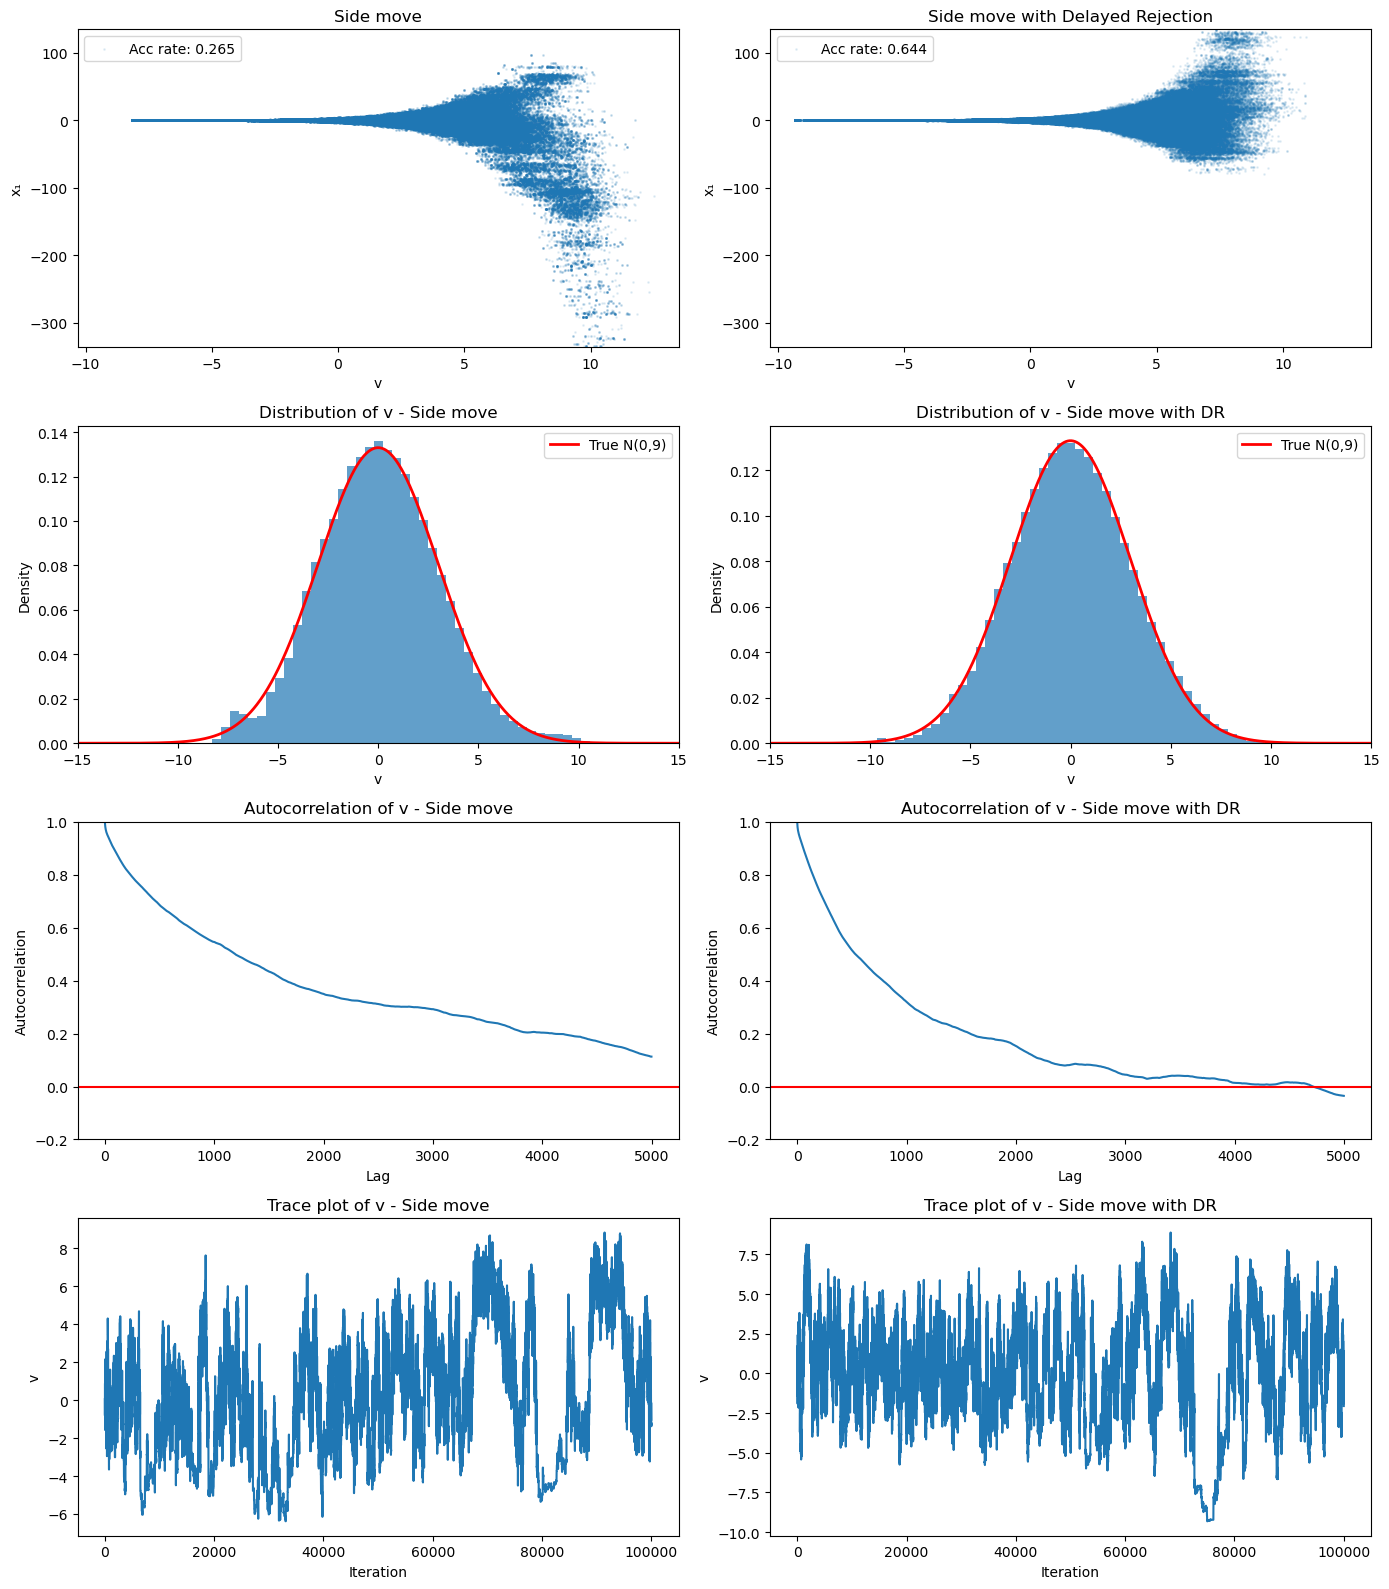

Effective Sample Size (ESS) for variable v:
  Side move: 25 (ratio: 0.000)
  Side move with DR: 57 (ratio: 0.001)
KL divergence to true N(0,9) distribution for v:
  Side move: 0.0105
  Side move with DR: 0.0037


In [307]:
def funnel_log_prob(x):
    """
    Neal's funnel distribution log probability.
    First dimension determines the variance of other dimensions.
    """
    if x.ndim == 1:
        x = x.reshape(1, -1)
    
    v = x[:, 0]  # First dimension is v
    log_prob_v = -0.5 * v**2/9  # Prior on v ~ N(0, 9)
    
    # Other dimensions have variance exp(v)
    x_given_v = x[:, 1:]
    d = x_given_v.shape[1]
    log_prob_x_given_v = -0.5 * np.sum(x_given_v**2 / np.exp(v).reshape(-1, 1), axis=1) - 0.5 * d * v
    
    return log_prob_v + log_prob_x_given_v

def test_mcmc_on_funnel():
    """Test the MCMC samplers on the funnel distribution."""
    np.random.seed(42)
    
    # Problem dimension and parameters
    dim = 5
    n_samples = 10**5
    n_walkers = 4*dim
    initial = np.zeros(dim)
    
    print("Testing on funnel distribution...")
    
    # Run standard side move
    samples_standard, acc_rates_standard = side_move(
        funnel_log_prob, initial, n_samples, n_walkers, gamma=1.6869)
    print(f"Side move acceptance rate: {np.mean(acc_rates_standard):.3f}")
    
    # Run side move with delayed rejection
    # samples_dr, acc_rates_dr, dr_stats = side_move_with_dr(
    #     funnel_log_prob, initial, n_samples, n_walkers, n_try=2, shrink_factor=0.2, gamma=1.6869)
    # print(f"Side move with DR acceptance rate: {np.mean(acc_rates_dr):.3f}")
    
    samples_dr, acc_rates_dr, dr_stats = side_move_with_twostage_dr(
        funnel_log_prob, initial, n_samples, n_walkers, shrink_factor=0.2, gamma=1.6869)
    print(f"Side move with DR acceptance rate: {np.mean(acc_rates_dr):.3f}")

    # Print DR statistics
    print("Delayed rejection statistics:")
    for i in range(len(dr_stats['attempts'])):
        print(f"  Attempt {i+1}: {dr_stats['successes'][i]}/{dr_stats['attempts'][i]} " 
              f"({dr_stats['rates'][i]:.3f})")
    
    # Flatten samples for analysis (discarding burn-in)
    burn_in = 10**4
    combined_samples_standard = samples_standard[:, burn_in:, :].reshape(-1, dim)
    combined_samples_dr = samples_dr[:, burn_in:, :].reshape(-1, dim)
    
    # Create a grid for plots (4 rows, 2 columns)
    fig, axs = plt.subplots(4, 2, figsize=(14, 16))
    
    # Row 1: Scatter plots for the first two dimensions
    axs[0, 0].scatter(combined_samples_standard[:, 0], combined_samples_standard[:, 1], 
                alpha=0.1, s=1, label=f'Acc rate: {np.mean(acc_rates_standard):.3f}')
    axs[0, 0].set_title('Side move')
    axs[0, 0].set_xlabel('v')
    axs[0, 0].set_ylabel('x₁')
    # Set axis limits for better comparison
    v_limits = [min(combined_samples_standard[:, 0].min(), combined_samples_dr[:, 0].min()) - 1, 
                max(combined_samples_standard[:, 0].max(), combined_samples_dr[:, 0].max()) + 1]
    x1_limits = [min(combined_samples_standard[:, 1].min(), combined_samples_dr[:, 1].min()) - 1, 
                 max(combined_samples_standard[:, 1].max(), combined_samples_dr[:, 1].max()) + 1]
    axs[0, 0].set_xlim(v_limits)
    axs[0, 0].set_ylim(x1_limits)
    axs[0, 0].legend()
    
    axs[0, 1].scatter(combined_samples_dr[:, 0], combined_samples_dr[:, 1], 
                alpha=0.1, s=1, label=f'Acc rate: {np.mean(acc_rates_dr):.3f}')
    axs[0, 1].set_title('Side move with Delayed Rejection')
    axs[0, 1].set_xlabel('v')
    axs[0, 1].set_ylabel('x₁')
    axs[0, 1].set_xlim(v_limits)
    axs[0, 1].set_ylim(x1_limits)
    axs[0, 1].legend()
    
    # Row 2: Distribution of v
    bins = np.linspace(-11, 11, 50)
    axs[1, 0].hist(combined_samples_standard[:, 0], bins=bins, alpha=0.7, density=True)
    # True distribution of v is N(0, 9)
    x = np.linspace(-15, 15, 1000)
    true_density = np.exp(-0.5 * x**2/9) / np.sqrt(2 * np.pi*9)
    axs[1, 0].plot(x, true_density, 'r-', lw=2, label='True N(0,9)')
    axs[1, 0].set_title('Distribution of v - Side move')
    axs[1, 0].set_xlabel('v')
    axs[1, 0].set_ylabel('Density')
    axs[1, 0].set_xlim([-15, 15])
    axs[1, 0].legend()
    
    axs[1, 1].hist(combined_samples_dr[:, 0], bins=bins, alpha=0.7, density=True)
    axs[1, 1].plot(x, true_density, 'r-', lw=2, label='True N(0,9)')
    axs[1, 1].set_title('Distribution of v - Side move with DR')
    axs[1, 1].set_xlabel('v')
    axs[1, 1].set_ylabel('Density')
    axs[1, 1].set_xlim([-15, 15])
    axs[1, 1].legend()
    
    # Row 3: Autocorrelation of v
    # Use first walker for autocorrelation
    v_trace_standard = samples_standard[0, :, 0]
    v_trace_dr = samples_dr[0, :, 0]
    
    max_lag = 5000
    acorr_standard = autocorrelation_fft(v_trace_standard, max_lag)
    acorr_dr = autocorrelation_fft(v_trace_dr, max_lag)
    
    lags = np.arange(max_lag)
    axs[2, 0].plot(lags, acorr_standard)
    axs[2, 0].set_title('Autocorrelation of v - Side move')
    axs[2, 0].set_xlabel('Lag')
    axs[2, 0].set_ylabel('Autocorrelation')
    axs[2, 0].set_ylim([-0.2, 1.0])
    axs[2, 0].axhline(y=0, color='r', linestyle='-')
    
    axs[2, 1].plot(lags, acorr_dr)
    axs[2, 1].set_title('Autocorrelation of v - Side move with DR')
    axs[2, 1].set_xlabel('Lag')
    axs[2, 1].set_ylabel('Autocorrelation')
    axs[2, 1].set_ylim([-0.2, 1.0])
    axs[2, 1].axhline(y=0, color='r', linestyle='-')
    
    # Row 4: Trace plots of v for first walker
    timesteps = np.arange(n_samples)
    axs[3, 0].plot(timesteps, samples_standard[0, :, 0])
    axs[3, 0].set_title('Trace plot of v - Side move')
    axs[3, 0].set_xlabel('Iteration')
    axs[3, 0].set_ylabel('v')
    
    axs[3, 1].plot(timesteps, samples_dr[0, :, 0])
    axs[3, 1].set_title('Trace plot of v - Side move with DR')
    axs[3, 1].set_xlabel('Iteration')
    axs[3, 1].set_ylabel('v')
    
    plt.tight_layout()
    plt.show()
    
    # Additional diagnostic: Calculate effective sample size (ESS)
    def calculate_ess(chain, max_lag=10000):
        """Calculate effective sample size using autocorrelation."""
        n = len(chain)
        if n <= 1:
            return 0
            
        # Calculate autocorrelation
        acf = autocorrelation_fft(chain, min(max_lag, n-1))
        
        # Find where autocorrelation falls below 0.05
        # or use all available if it doesn't
        cutoff = np.argmax(np.abs(acf[1:]) < 0.05)
        if cutoff == 0:  # No value below threshold
            cutoff = min(len(acf), max_lag) - 1
        
        # Calculate ESS using sum of autocorrelations
        ess = n / (1 + 2 * np.sum(acf[1:cutoff+1]))
        return max(1, ess)  # Ensure at least 1
    
    # Calculate ESS for each method
    ess_standard = calculate_ess(v_trace_standard)
    ess_dr = calculate_ess(v_trace_dr)
    
    print(f"Effective Sample Size (ESS) for variable v:")
    print(f"  Side move: {ess_standard:.0f} (ratio: {ess_standard/len(v_trace_standard):.3f})")
    print(f"  Side move with DR: {ess_dr:.0f} (ratio: {ess_dr/len(v_trace_dr):.3f})")
    
    # Calculate KL divergence to true distribution
    def kl_to_normal(samples, true_mean=0, true_var=9, bins=100):
        """Approximate KL divergence from samples to normal distribution."""
        hist, bin_edges = np.histogram(samples, bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Calculate true normal density at bin centers
        true_density = np.exp(-0.5 * (bin_centers - true_mean)**2 / true_var) / np.sqrt(2 * np.pi * true_var)
        
        # Calculate KL divergence, avoiding division by zero and log(0)
        nonzero = (hist > 0) & (true_density > 0)
        if not np.any(nonzero):
            return np.inf
            
        kl = np.sum(hist[nonzero] * np.log(hist[nonzero] / true_density[nonzero])) * (bin_edges[1] - bin_edges[0])
        return kl
    
    # Calculate KL divergence for each method
    kl_standard = kl_to_normal(combined_samples_standard[:, 0])
    kl_dr = kl_to_normal(combined_samples_dr[:, 0])
    
    print(f"KL divergence to true N(0,9) distribution for v:")
    print(f"  Side move: {kl_standard:.4f}")
    print(f"  Side move with DR: {kl_dr:.4f}")
    
    # Return the samples for further analysis if needed
    return samples_standard, samples_dr, acc_rates_standard, acc_rates_dr, dr_stats


if __name__ == "__main__":
    test_mcmc_on_funnel()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def stretch_move(log_prob, initial, n_samples, n_walkers=20, a=2.151):
    """
    Vectorized implementation of the Ensemble MCMC with stretch moves.
    
    Parameters:
    -----------
    log_prob : function
        Log probability density function that accepts array of shape (n_walkers, dim)
        and returns array of shape (n_walkers,)
    initial : array
        Initial state (will be used as mean for initializing walkers)
    n_samples : int
        Number of samples to draw per walker
    n_walkers : int
        Number of walkers in the ensemble (must be even)
    a : float
        Stretch parameter (controls proposal scale)
        
    Returns:
    --------
    samples : array
        Samples from all walkers (shape: n_walkers, n_samples, dim)
    acceptance_rates : array
        Acceptance rates for all walkers
    """
    # Ensure even number of walkers
    if n_walkers % 2 != 0:
        n_walkers += 1
        
    dim = len(initial)
    half_walkers = n_walkers // 2

    a = 1+ a / np.sqrt(dim) # Optimal scaling for Gaussian targets

    # Initialize walkers with small random perturbations around initial
    walkers = np.tile(initial, (n_walkers, 1)) + 0.1 * np.random.randn(n_walkers, dim)
    
    # Vectorized evaluation of initial log probabilities
    walker_log_probs = log_prob(walkers)
    
    # Storage for samples and tracking acceptance
    samples = np.zeros((n_walkers, n_samples, dim))
    accepts = np.zeros(n_walkers)
    
    # Main sampling loop
    for i in range(n_samples):
        # Store current state from all walkers
        samples[:, i] = walkers
        
        # Update first half, then second half
        for half in [0, 1]:
            # Set indices for active and complementary walker sets
            active_indices = np.arange(half * half_walkers, (half + 1) * half_walkers)
            comp_indices = np.arange((1 - half) * half_walkers, (2 - half) * half_walkers)
            
            # Randomly select complementary walkers for each active walker
            selected_comp_indices = np.random.choice(comp_indices, size=half_walkers, replace=True)
            
            # Generate stretch factors (z) for all active walkers at once
            z_factors = ((a - 1.0) * np.random.uniform(size=half_walkers) + 1.0) ** 2.0 / a
            
            # Extract active and selected complementary walkers
            active_walkers = walkers[active_indices]
            comp_walkers = walkers[selected_comp_indices]
            
            # Vectorized proposal generation for all active walkers at once
            # z * (Xactive - Xcomp) + Xcomp = Xcomp + z * (Xactive - Xcomp)
            proposals = comp_walkers + (active_walkers - comp_walkers) * z_factors[:, np.newaxis]
            
            # Evaluate all proposals at once
            proposal_log_probs = log_prob(proposals)
            
            # Calculate log acceptance probabilities
            log_accept_probs = (dim - 1) * np.log(z_factors) + proposal_log_probs - walker_log_probs[active_indices]
            
            # Generate random numbers for acceptance decisions
            random_uniforms = np.log(np.random.uniform(size=half_walkers))
            
            # Determine which proposals are accepted
            accepted = random_uniforms < log_accept_probs
            
            # Update walkers and log probabilities in one step
            walkers[active_indices[accepted]] = proposals[accepted]
            walker_log_probs[active_indices[accepted]] = proposal_log_probs[accepted]
            
            # Track acceptance for all walkers
            accepts[active_indices[accepted]] += 1
    
    # Return results from all walkers
    acceptance_rates = accepts / n_samples
    return samples, acceptance_rates



import numpy as np

def stretch_move_with_twostage_dr(log_prob, initial, n_samples, n_walkers=20, a=2.151, 
                        shrink_factor=0.5):
    """
    Vectorized stretch move with two-step delayed rejection.
    Maintains the efficiency of the original stretch move.
    """
    # Ensure even number of walkers
    if n_walkers % 2 != 0:
        n_walkers += 1
        
    dim = len(initial)
    half_walkers = n_walkers // 2
    
    # Scale parameter by dimension
    a_scaled = 1 + a / np.sqrt(dim)
    
    # Initialize walkers
    walkers = np.tile(initial, (n_walkers, 1)) + 0.1 * np.random.randn(n_walkers, dim)
    walker_log_probs = log_prob(walkers)
    
    # Storage
    samples = np.zeros((n_walkers, n_samples, dim))
    accepts = np.zeros(n_walkers)
    dr_attempts = np.zeros(2)  # [first_attempts, second_attempts]
    dr_successes = np.zeros(2)  # [first_successes, second_successes]
    
    # Main sampling loop
    for i in range(n_samples):
        samples[:, i] = walkers
        
        # Update first half, then second half
        for half in [0, 1]:
            active_indices = np.arange(half * half_walkers, (half + 1) * half_walkers)
            comp_indices = np.arange((1 - half) * half_walkers, (2 - half) * half_walkers)
            
            # Randomly select complementary walkers for each active walker
            selected_comp_indices = np.random.choice(comp_indices, size=half_walkers, replace=True)
            
            # Extract active and selected complementary walkers
            active_walkers = walkers[active_indices]
            comp_walkers = walkers[selected_comp_indices]
            
            # FIRST ATTEMPT - Vectorized
            dr_attempts[0] += half_walkers
            
            # Generate stretch factors for all active walkers
            z1_factors = ((a_scaled - 1.0) * np.random.uniform(size=half_walkers) + 1.0) ** 2.0 / a_scaled
            
            # Vectorized proposal generation
            proposals1 = comp_walkers + (active_walkers - comp_walkers) * z1_factors[:, np.newaxis]
            
            # Evaluate all first proposals at once
            proposal1_log_probs = log_prob(proposals1)
            
            # Calculate log acceptance probabilities for first attempt
            log_accept_probs1 = ((dim - 1) * np.log(z1_factors) + 
                                proposal1_log_probs - walker_log_probs[active_indices])
            
            # Generate random numbers for acceptance decisions
            random_uniforms1 = np.log(np.random.uniform(size=half_walkers))
            
            # Determine which first proposals are accepted
            accepted1 = (random_uniforms1 < log_accept_probs1) & (proposal1_log_probs != -np.inf)
            
            # Update accepted walkers from first attempt
            walkers[active_indices[accepted1]] = proposals1[accepted1]
            walker_log_probs[active_indices[accepted1]] = proposal1_log_probs[accepted1]
            accepts[active_indices[accepted1]] += 1
            dr_successes[0] += np.sum(accepted1)
            
            # SECOND ATTEMPT - Only for rejected walkers
            rejected_mask = ~accepted1
            if np.any(rejected_mask):
                n_rejected = np.sum(rejected_mask)
                dr_attempts[1] += n_rejected
                
                # Get rejected walker data
                rejected_active_indices = active_indices[rejected_mask]
                rejected_active_walkers = active_walkers[rejected_mask]
                rejected_comp_walkers = comp_walkers[rejected_mask]
                rejected_proposal1_logps = proposal1_log_probs[rejected_mask]
                rejected_z1_factors = z1_factors[rejected_mask]
                
                # Generate second attempt with reduced stretch parameter
                a2 = a_scaled * shrink_factor
                z2_factors = ((a2 - 1.0) * np.random.uniform(size=n_rejected) + 1.0) ** 2.0 / a2
                
                # Vectorized second proposal generation (using same complementary walkers)
                proposals2 = rejected_comp_walkers + (rejected_active_walkers - rejected_comp_walkers) * z2_factors[:, np.newaxis]
                
                # Evaluate all second proposals at once
                proposal2_log_probs = log_prob(proposals2)
                
                # Calculate log acceptance probabilities for second attempt
                log_accept_probs2 = ((dim - 1) * np.log(z2_factors) + 
                                    proposal2_log_probs - walker_log_probs[rejected_active_indices])
                
                #### DR correction
                is_in_support = (rejected_z1_factors/z2_factors >=  1/a_scaled) * (rejected_z1_factors/z2_factors <= a_scaled)
                reverse_log_accept_probs1 = ((dim - 1) * np.log(rejected_z1_factors/z2_factors) -
                                proposal2_log_probs + rejected_proposal1_logps)
                reverse_log_accept_probs1[is_in_support==0] = -np.inf
                # print(reverse_log_accept_probs1)
            
                DR_reverse_reject = np.log1p(-np.exp(np.minimum(0.0, reverse_log_accept_probs1)))
                DR_forward_reject = np.log1p(-np.exp(np.minimum(0.0, log_accept_probs1[rejected_mask])))
                log_accept_probs2 += DR_reverse_reject - DR_forward_reject - 0.5*np.log(z2_factors)
                log_accept_probs2[is_in_support==0] = -np.inf
                    
                
                # Generate random numbers for second acceptance decisions
                random_uniforms2 = np.log(np.random.uniform(size=n_rejected))
                
                # Determine which second proposals are accepted
                accepted2 = (random_uniforms2 < log_accept_probs2) & (proposal2_log_probs != -np.inf)
                
                # Update accepted walkers from second attempt
                final_accepted_indices = rejected_active_indices[accepted2]
                walkers[final_accepted_indices] = proposals2[accepted2]
                walker_log_probs[final_accepted_indices] = proposal2_log_probs[accepted2]
                accepts[final_accepted_indices] += 1
                dr_successes[1] += np.sum(accepted2)
    
    acceptance_rates = accepts / n_samples
    dr_stats = {
        'attempts': dr_attempts,
        'successes': dr_successes,
        'rates': dr_successes / np.maximum(dr_attempts, 1)
    }
    return samples, acceptance_rates, dr_stats

Testing on funnel distribution...
Stretch move acceptance rate: 0.189


/var/folders/r1/mcbxhrz15w781rksjrkrm5sr0000gn/T/ipykernel_54725/3227563746.py:204: RuntimeWarning: divide by zero encountered in log1p
  DR_reverse_reject = np.log1p(-np.exp(np.minimum(0.0, reverse_log_accept_probs1)))


Stretch move with DR acceptance rate: 0.637
Delayed rejection statistics:
  Attempt 1: 1660400.0/8800000.0 (0.189)
  Attempt 2: 3948340.0/7139600.0 (0.553)


/var/folders/r1/mcbxhrz15w781rksjrkrm5sr0000gn/T/ipykernel_54725/3202814306.py:147: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


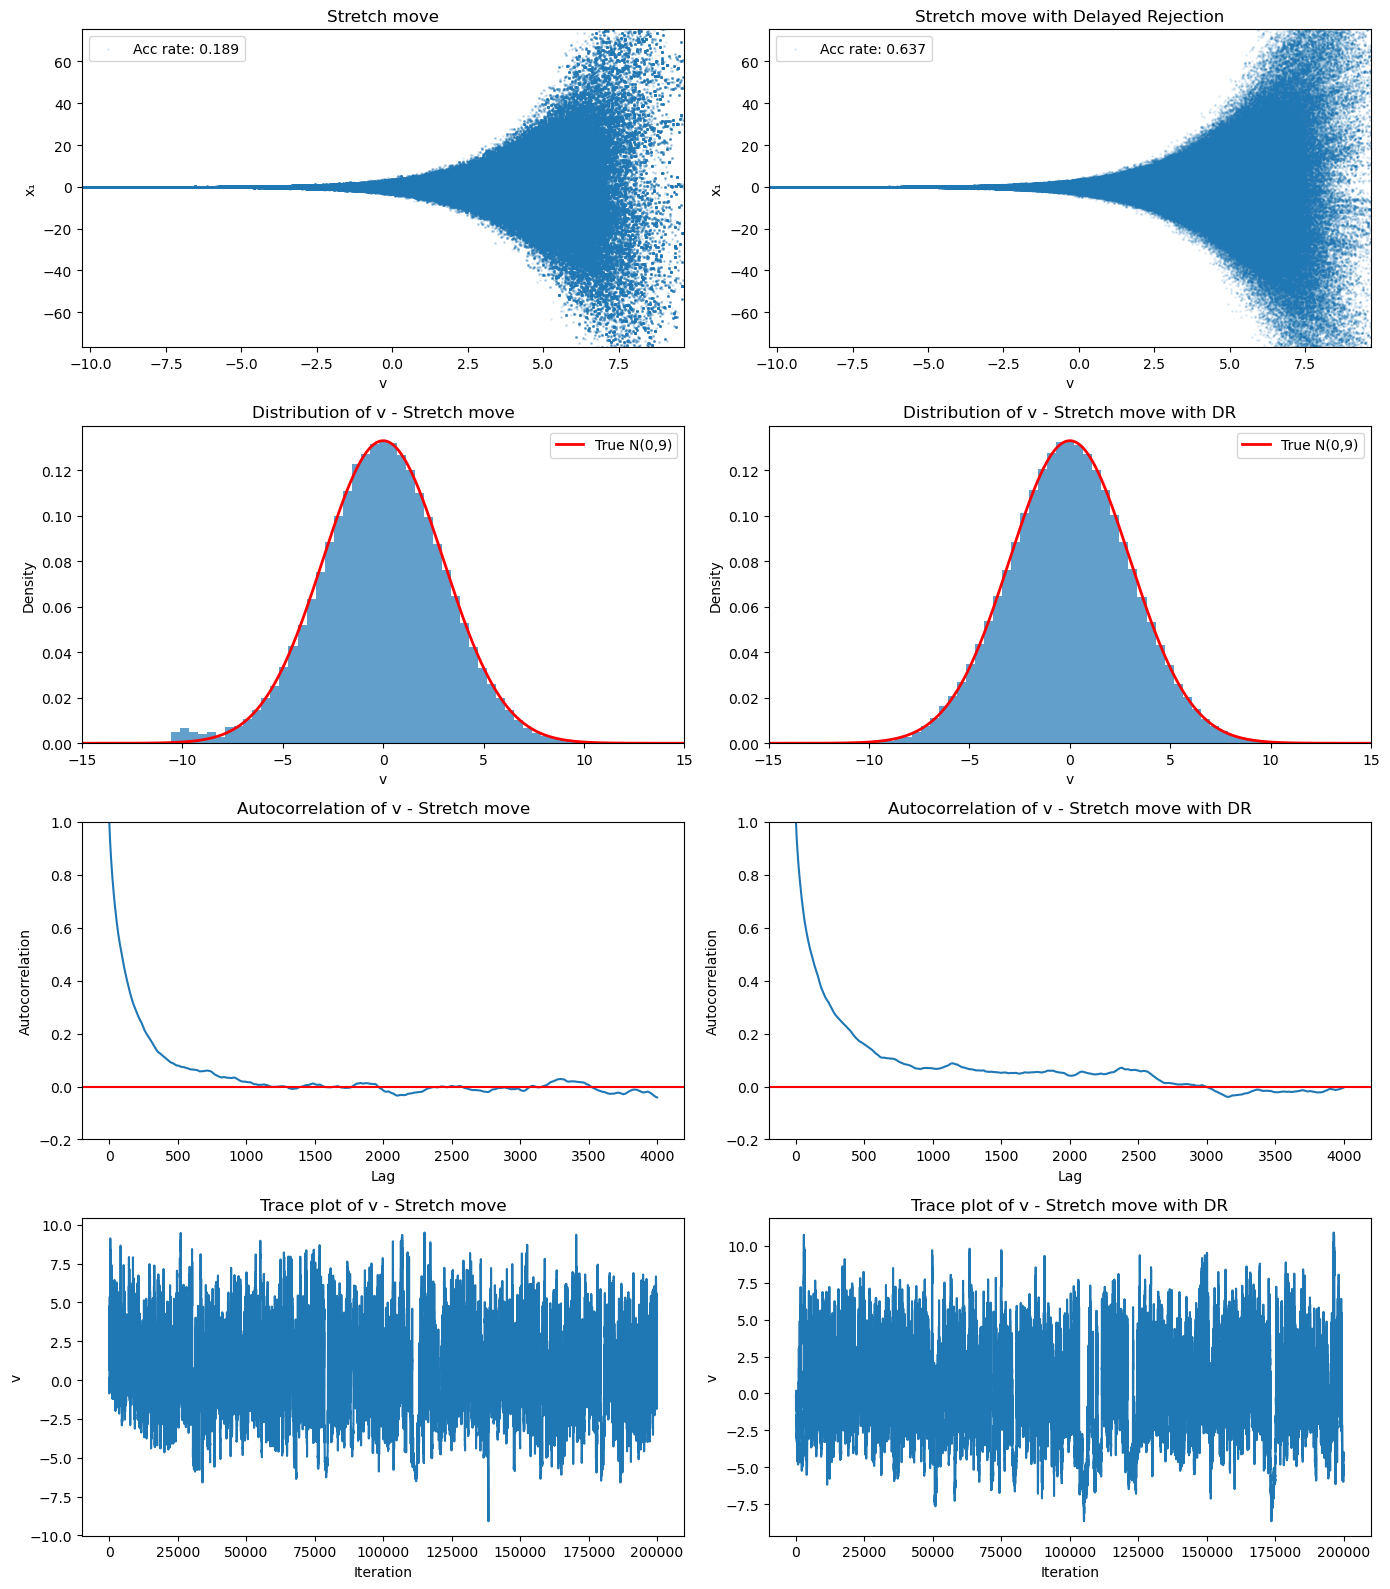

Effective Sample Size (ESS) for variable v:
  Stretch move: 604 (ratio: 0.003)
  Stretch move with DR: 365 (ratio: 0.002)
KL divergence to true N(0,9) distribution for v:
  Stretch move: 0.0124
  Stretch move with DR: 0.0005


In [6]:
def funnel_log_prob(x):
    """
    Neal's funnel distribution log probability.
    First dimension determines the variance of other dimensions.
    """
    if x.ndim == 1:
        x = x.reshape(1, -1)
    
    v = x[:, 0]  # First dimension is v
    log_prob_v = -0.5 * v**2/9  # Prior on v ~ N(0, 9)
    
    # Other dimensions have variance exp(v)
    x_given_v = x[:, 1:]
    d = x_given_v.shape[1]
    log_prob_x_given_v = -0.5 * np.sum(x_given_v**2 / np.exp(v).reshape(-1, 1), axis=1) - 0.5 * d * v
    
    return log_prob_v + log_prob_x_given_v


def test_mcmc_on_funnel():
    """Test the MCMC samplers on the funnel distribution."""
    np.random.seed(42)
    
    # Problem dimension and parameters
    dim = 11
    n_samples = 2*10**5
    n_walkers = 4*dim
    initial = np.zeros(dim)
    
    print("Testing on funnel distribution...")
    
    # Run standard stretch move (vectorized)
    samples_standard, acc_rates_standard = stretch_move(
        funnel_log_prob, initial, n_samples, n_walkers, a=10)
    print(f"Stretch move acceptance rate: {np.mean(acc_rates_standard):.3f}")
    
    # Run stretch move with delayed rejection (vectorized)
    # Use more conservative settings for delayed rejection
    samples_dr, acc_rates_dr, dr_stats = stretch_move_with_twostage_dr(
        funnel_log_prob, initial, n_samples, n_walkers, shrink_factor=0.3, a=10)
    print(f"Stretch move with DR acceptance rate: {np.mean(acc_rates_dr):.3f}")
    
    # Print DR statistics
    print("Delayed rejection statistics:")
    for i in range(len(dr_stats['attempts'])):
        print(f"  Attempt {i+1}: {dr_stats['successes'][i]}/{dr_stats['attempts'][i]} " 
              f"({dr_stats['rates'][i]:.3f})")
    
    # Flatten samples for analysis (discarding burn-in)
    burn_in = 4*10**4
    combined_samples_standard = samples_standard[:, burn_in:, :].reshape(-1, dim)
    combined_samples_dr = samples_dr[:, burn_in:, :].reshape(-1, dim)
    
    # Create a grid for plots (4 rows, 2 columns)
    fig, axs = plt.subplots(4, 2, figsize=(14, 16))
    
    # Row 1: Scatter plots for the first two dimensions
    axs[0, 0].scatter(combined_samples_standard[:, 0], combined_samples_standard[:, 1], 
                alpha=0.1, s=1, label=f'Acc rate: {np.mean(acc_rates_standard):.3f}')
    axs[0, 0].set_title('Stretch move')
    axs[0, 0].set_xlabel('v')
    axs[0, 0].set_ylabel('x₁')
    
    # Get common axis limits
    v_min = min(np.percentile(combined_samples_standard[:, 0], 0.1), 
               np.percentile(combined_samples_dr[:, 0], 0.1))
    v_max = max(np.percentile(combined_samples_standard[:, 0], 99.9), 
               np.percentile(combined_samples_dr[:, 0], 99.9))
    x1_min = min(np.percentile(combined_samples_standard[:, 1], 0.1), 
                np.percentile(combined_samples_dr[:, 1], 0.1))
    x1_max = max(np.percentile(combined_samples_standard[:, 1], 99.9), 
                np.percentile(combined_samples_dr[:, 1], 99.9))
    
    v_limits = [v_min, v_max]
    x1_limits = [x1_min, x1_max]
    
    axs[0, 0].set_xlim(v_limits)
    axs[0, 0].set_ylim(x1_limits)
    axs[0, 0].legend()
    
    axs[0, 1].scatter(combined_samples_dr[:, 0], combined_samples_dr[:, 1], 
                alpha=0.1, s=1, label=f'Acc rate: {np.mean(acc_rates_dr):.3f}')
    axs[0, 1].set_title('Stretch move with Delayed Rejection')
    axs[0, 1].set_xlabel('v')
    axs[0, 1].set_ylabel('x₁')
    axs[0, 1].set_xlim(v_limits)
    axs[0, 1].set_ylim(x1_limits)
    axs[0, 1].legend()
    
    # Row 2: Distribution of v
    bins = np.linspace(-11, 11, 50)
    axs[1, 0].hist(combined_samples_standard[:, 0], bins=bins, alpha=0.7, density=True)
    # True distribution of v is N(0, 9)
    x = np.linspace(-15, 15, 1000)
    true_density = np.exp(-0.5 * x**2/9) / np.sqrt(2 * np.pi*9)
    axs[1, 0].plot(x, true_density, 'r-', lw=2, label='True N(0,9)')
    axs[1, 0].set_title('Distribution of v - Stretch move')
    axs[1, 0].set_xlabel('v')
    axs[1, 0].set_ylabel('Density')
    axs[1, 0].set_xlim([-15, 15])
    axs[1, 0].legend()
    
    axs[1, 1].hist(combined_samples_dr[:, 0], bins=bins, alpha=0.7, density=True)
    axs[1, 1].plot(x, true_density, 'r-', lw=2, label='True N(0,9)')
    axs[1, 1].set_title('Distribution of v - Stretch move with DR')
    axs[1, 1].set_xlabel('v')
    axs[1, 1].set_ylabel('Density')
    axs[1, 1].set_xlim([-15, 15])
    axs[1, 1].legend()
    
    # Row 3: Autocorrelation of v
    # Use first walker for autocorrelation
    v_trace_standard = samples_standard[0, :, 0]
    v_trace_dr = samples_dr[0, :, 0]
    
    max_lag = 4000
    acorr_standard = autocorrelation_fft(v_trace_standard, max_lag)
    acorr_dr = autocorrelation_fft(v_trace_dr, max_lag)
    
    lags = np.arange(max_lag)
    axs[2, 0].plot(lags, acorr_standard)
    axs[2, 0].set_title('Autocorrelation of v - Stretch move')
    axs[2, 0].set_xlabel('Lag')
    axs[2, 0].set_ylabel('Autocorrelation')
    axs[2, 0].set_ylim([-0.2, 1.0])
    axs[2, 0].axhline(y=0, color='r', linestyle='-')
    
    axs[2, 1].plot(lags, acorr_dr)
    axs[2, 1].set_title('Autocorrelation of v - Stretch move with DR')
    axs[2, 1].set_xlabel('Lag')
    axs[2, 1].set_ylabel('Autocorrelation')
    axs[2, 1].set_ylim([-0.2, 1.0])
    axs[2, 1].axhline(y=0, color='r', linestyle='-')
    
    # Row 4: Trace plots of v for first walker
    timesteps = np.arange(n_samples)
    axs[3, 0].plot(timesteps, samples_standard[0, :, 0])
    axs[3, 0].set_title('Trace plot of v - Stretch move')
    axs[3, 0].set_xlabel('Iteration')
    axs[3, 0].set_ylabel('v')
    
    axs[3, 1].plot(timesteps, samples_dr[0, :, 0])
    axs[3, 1].set_title('Trace plot of v - Stretch move with DR')
    axs[3, 1].set_xlabel('Iteration')
    axs[3, 1].set_ylabel('v')
    
    plt.tight_layout()
    plt.show()
    
    # Additional diagnostic: Calculate effective sample size (ESS)
    def calculate_ess(chain, max_lag=10000):
        """Calculate effective sample size using autocorrelation."""
        n = len(chain)
        if n <= 1:
            return 0
            
        # Calculate autocorrelation
        acf = autocorrelation_fft(chain, min(max_lag, n-1))
        
        # Find where autocorrelation falls below 0.05
        # or use all available if it doesn't
        cutoff = np.argmax(np.abs(acf[1:]) < 0.05)
        if cutoff == 0:  # No value below threshold
            cutoff = min(len(acf), max_lag) - 1
        
        # Calculate ESS using sum of autocorrelations
        ess = n / (1 + 2 * np.sum(acf[1:cutoff+1]))
        return max(1, ess)  # Ensure at least 1
    
    # Calculate ESS for each method
    ess_standard = calculate_ess(v_trace_standard)
    ess_dr = calculate_ess(v_trace_dr)
    
    print(f"Effective Sample Size (ESS) for variable v:")
    print(f"  Stretch move: {ess_standard:.0f} (ratio: {ess_standard/len(v_trace_standard):.3f})")
    print(f"  Stretch move with DR: {ess_dr:.0f} (ratio: {ess_dr/len(v_trace_dr):.3f})")
    
    # Calculate KL divergence to true distribution
    def kl_to_normal(samples, true_mean=0, true_var=9, bins=100):
        """Approximate KL divergence from samples to normal distribution."""
        hist, bin_edges = np.histogram(samples, bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Calculate true normal density at bin centers
        true_density = np.exp(-0.5 * (bin_centers - true_mean)**2 / true_var) / np.sqrt(2 * np.pi * true_var)
        
        # Calculate KL divergence, avoiding division by zero and log(0)
        nonzero = (hist > 0) & (true_density > 0)
        if not np.any(nonzero):
            return np.inf
            
        kl = np.sum(hist[nonzero] * np.log(hist[nonzero] / true_density[nonzero])) * (bin_edges[1] - bin_edges[0])
        return kl
    
    # Calculate KL divergence for each method
    kl_standard = kl_to_normal(combined_samples_standard[:, 0])
    kl_dr = kl_to_normal(combined_samples_dr[:, 0])
    
    print(f"KL divergence to true N(0,9) distribution for v:")
    print(f"  Stretch move: {kl_standard:.4f}")
    print(f"  Stretch move with DR: {kl_dr:.4f}")
    
    # Return the samples for further analysis if needed
    return samples_standard, samples_dr, acc_rates_standard, acc_rates_dr, dr_stats



samples_standard, samples_dr, acc_rates_standard, acc_rates_dr, dr_stats = test_mcmc_on_funnel()

DR
204.96371980676625 975.782446710833
137.4179227037645 1455.4142288349487
156.40269873558822 1278.7503132418235
89.1798130636414 2242.660004874354
104.57711216347558 1912.4643611056958
no DR
287.8939813641869 694.7001776567163
170.09395207210727 1175.820760018644
132.4715729788025 1509.7578710868263
119.50787451535912 1673.5298892316594
143.9371681393555 1389.49517060365


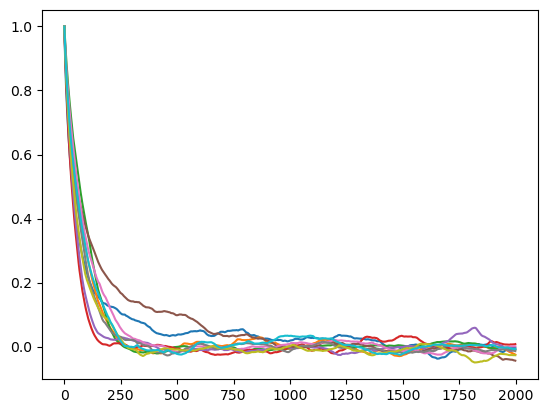

In [8]:
print('DR')
acf = np.zeros((2000, 5))
for i in range(5):
    acf[:, i] = autocorrelation_fft(samples_dr[0,:, i], max_lag=2000)
plt.plot(range(2000), acf)
for i in range(5):
    tau, acf, ess = integrated_autocorr_time(samples_dr[0,:, i], M=5, c=10)
    print(tau, ess)

print('no DR')
acf = np.zeros((2000, 5))
for i in range(5):
    acf[:, i] = autocorrelation_fft(samples_standard[0,:, i], max_lag=2000)
plt.plot(range(2000), acf)
for i in range(5):
    tau, acf, ess = integrated_autocorr_time(samples_standard[0,:, i], M=5, c=10)
    print(tau, ess)


In [9]:
# import numpy as np
# from scipy.linalg import cholesky, solve_triangular

# def compute_transition_probability_chol(start_state, end_state, start_grad, start_chol, step_size):
#     """Compute log transition probability using Cholesky decomposition."""
#     y = solve_triangular(start_chol, start_grad, lower=True)
#     drift = solve_triangular(start_chol.T, y, lower=False)
    
#     mean = start_state + step_size * drift
#     diff = end_state - mean
#     Lt_diff = start_chol.T @ diff
#     quad_form = np.sum(Lt_diff**2) / (2 * step_size)
    
#     d = len(start_state)
#     log_det = d * np.log(4 * np.pi * step_size) - 2 * np.sum(np.log(np.diag(start_chol)))
    
#     return -0.5 * (quad_form + log_det)

# def regularize_and_cholesky(hess, eye, reg_small=1e-6, reg_large=1e-3):
#     """Regularize Hessian and return Cholesky decomposition."""
#     hess_reg = 0.5 * (hess + hess.T) + reg_small * eye
#     try:
#         return cholesky(hess_reg, lower=True)
#     except np.linalg.LinAlgError:
#         hess_reg += reg_large * eye
#         return cholesky(hess_reg, lower=True)

# def compute_dr_acceptance_correct(current_idx, proposal_idx, prev_proposal_indices,
#                                  all_logps, all_states, all_gradients, all_chols, step_sizes):
#     """
#     Correct delayed rejection acceptance computation.
    
#     Key insight: The kernel used for any transition depends on the number of 
#     rejection states in the current context. If we have k rejections, we use kernel k+1.
#     """
#     # Number of rejections determines which kernel we're using
#     num_rejections = len(prev_proposal_indices)
#     kernel_idx = num_rejections  # 0 rejections → kernel 0, 1 rejection → kernel 1, etc.
#     current_step_size = step_sizes[kernel_idx]
    
#     if num_rejections == 0:
#         # Stage 1: Standard Metropolis-Hastings using kernel 0
#         q_forward = compute_transition_probability_chol(
#             all_states[current_idx], all_states[proposal_idx], 
#             all_gradients[current_idx], all_chols[current_idx], current_step_size)
#         q_backward = compute_transition_probability_chol(
#             all_states[proposal_idx], all_states[current_idx], 
#             all_gradients[proposal_idx], all_chols[proposal_idx], current_step_size)
        
#         log_ratio = (all_logps[proposal_idx] - all_logps[current_idx] + 
#                      q_backward - q_forward)
#         return min(0.0, log_ratio)
    
#     # Stage k > 1: Delayed rejection formula
#     # All transitions in this formula use the kernel corresponding to current number of rejections
    
#     # Main transition terms - use current kernel
#     q_prop_to_curr = compute_transition_probability_chol(
#         all_states[proposal_idx], all_states[current_idx], 
#         all_gradients[proposal_idx], all_chols[proposal_idx], current_step_size)
#     q_curr_to_prop = compute_transition_probability_chol(
#         all_states[current_idx], all_states[proposal_idx], 
#         all_gradients[current_idx], all_chols[current_idx], current_step_size)
    
#     log_num = all_logps[proposal_idx] + q_prop_to_curr
#     log_denom = all_logps[current_idx] + q_curr_to_prop
    
#     # Proposal ratio corrections 
#     # Each transition to prev_idx uses the kernel corresponding to prev_idx
#     for prev_idx in prev_proposal_indices:
#         # Use kernel for prev_idx: if prev_idx=1 use kernel 0, if prev_idx=2 use kernel 1, etc.
#         prev_kernel_idx = prev_idx - 1
#         prev_step_size = step_sizes[prev_kernel_idx]
        
#         q_prop_to_prev = compute_transition_probability_chol(
#             all_states[proposal_idx], all_states[prev_idx], 
#             all_gradients[proposal_idx], all_chols[proposal_idx], prev_step_size)
#         q_curr_to_prev = compute_transition_probability_chol(
#             all_states[current_idx], all_states[prev_idx], 
#             all_gradients[current_idx], all_chols[current_idx], prev_step_size)
        
#         log_num += q_prop_to_prev
#         log_denom += q_curr_to_prev
    
#     # Rejection probability corrections (recursive terms)
#     # Each recursive call will have fewer rejections, so will use earlier kernels
#     for i, prev_idx in enumerate(prev_proposal_indices):
#         # prev_proposal_indices[:i] has i elements (i rejections)
#         # So these recursive calls use kernel i
#         alpha_current = compute_dr_acceptance_correct(
#             current_idx, prev_idx, prev_proposal_indices[:i], 
#             all_logps, all_states, all_gradients, all_chols, step_sizes)
#         alpha_proposal = compute_dr_acceptance_correct(
#             proposal_idx, prev_idx, prev_proposal_indices[:i], 
#             all_logps, all_states, all_gradients, all_chols, step_sizes)
        
#         if alpha_current > -1e-12:  # α ≈ 1, so (1-α) ≈ 0
#             return -np.inf
#         if alpha_proposal > -1e-12:  # α ≈ 1, so (1-α) ≈ 0  
#             return -np.inf
            
#         log_denom += np.log1p(-np.exp(alpha_current))
#         log_num += np.log1p(-np.exp(alpha_proposal))
    
#     return min(0.0, log_num - log_denom)

# def gnpl_metropolis_with_dr(log_posterior, gradient, hessian, initial_point, n_samples, 
#                             step_size=0.1, n_try=2, shrink_factor=0.5):
#     """
#     Correct GNPL with Delayed Rejection implementation.
    
#     Kernel selection based on number of rejections in each context.
#     """
#     dim = len(initial_point)
#     samples = np.zeros((n_samples, dim))
#     samples[0] = initial_point
    
#     accepted = 0
#     dr_attempts = np.zeros(n_try)
#     dr_successes = np.zeros(n_try)
#     eye = np.eye(dim)
    
#     for i in range(1, n_samples):
#         current = samples[i-1]
#         current_logp = log_posterior(current)
        
#         # Compute gradient and Hessian once for current state
#         current_grad = gradient(current)
#         current_hess = hessian(current)
#         current_chol = regularize_and_cholesky(current_hess, eye)
        
#         # Precompute drift for current state
#         y = solve_triangular(current_chol, current_grad, lower=True)
#         drift = solve_triangular(current_chol.T, y, lower=False)
        
#         # Generate ALL proposals at once (each from the original state)
#         all_states = [current.copy()]
#         all_logps = [current_logp]
#         all_gradients = [current_grad.copy()]
#         all_chols = [current_chol.copy()]
#         step_sizes = []
        
#         for attempt in range(n_try):
#             current_step_size = step_size * (shrink_factor ** attempt)
#             step_sizes.append(current_step_size)
            
#             # Generate proposal from original state using this step size
#             z = np.random.randn(dim)
#             noise_base = solve_triangular(current_chol.T, z, lower=False)
#             noise = np.sqrt(2 * current_step_size) * noise_base
#             proposal = current + current_step_size * drift + noise
            
#             proposal_logp = log_posterior(proposal)
#             all_states.append(proposal.copy())
#             all_logps.append(proposal_logp)
            
#             if proposal_logp == -np.inf:
#                 all_gradients.append(np.zeros_like(current_grad))
#                 all_chols.append(eye.copy())
#             else:
#                 proposal_grad = gradient(proposal)
#                 proposal_hess = hessian(proposal)
#                 proposal_chol = regularize_and_cholesky(proposal_hess, eye)
#                 all_gradients.append(proposal_grad.copy())
#                 all_chols.append(proposal_chol.copy())
        
#         # Test proposals in order using correct DR acceptance
#         accepted_proposal = False
#         for attempt in range(n_try):
#             dr_attempts[attempt] += 1
#             proposal_idx = attempt + 1
            
#             if all_logps[proposal_idx] == -np.inf:
#                 continue
            
#             prev_proposal_indices = list(range(1, proposal_idx))
            
#             log_accept_prob = compute_dr_acceptance_correct(
#                 0, proposal_idx, prev_proposal_indices, 
#                 all_logps, all_states, all_gradients, all_chols, step_sizes)
            
#             if np.log(np.random.rand()) < log_accept_prob:
#                 samples[i] = all_states[proposal_idx]
#                 accepted += 1
#                 dr_successes[attempt] += 1
#                 accepted_proposal = True
#                 break
        
#         if not accepted_proposal:
#             samples[i] = current
    
#     acceptance_rate = accepted / (n_samples - 1)
#     dr_stats = {
#         'attempts': dr_attempts,
#         'successes': dr_successes,
#         'rates': dr_successes / np.maximum(dr_attempts, 1)
#     }
#     return samples, acceptance_rate, dr_stats


#### memoized version with caching
import numpy as np
from scipy.linalg import cholesky, solve_triangular

def compute_transition_probability_chol(start_state, end_state, start_grad, start_chol, step_size):
    """Compute log transition probability using Cholesky decomposition."""
    y = solve_triangular(start_chol, start_grad, lower=True)
    drift = solve_triangular(start_chol.T, y, lower=False)
    
    mean = start_state + step_size * drift
    diff = end_state - mean
    Lt_diff = start_chol.T @ diff
    quad_form = np.sum(Lt_diff**2) / (2 * step_size)
    
    d = len(start_state)
    log_det = d * np.log(4 * np.pi * step_size) - 2 * np.sum(np.log(np.diag(start_chol)))
    
    return -0.5 * (quad_form + log_det)

def regularize_and_cholesky(hess, eye, reg_small=1e-6, reg_large=1e-3):
    """Regularize Hessian and return Cholesky decomposition."""
    hess_reg = 0.5 * (hess + hess.T) + reg_small * eye
    try:
        return cholesky(hess_reg, lower=True)
    except np.linalg.LinAlgError:
        hess_reg += reg_large * eye
        return cholesky(hess_reg, lower=True)

def compute_dr_acceptance_memoized(current_idx, proposal_idx, prev_proposal_indices,
                                  all_logps, all_states, all_gradients, all_chols, step_sizes,
                                  transition_cache, acceptance_cache):
    """
    Optimized delayed rejection acceptance with memoization.
    """
    # Create cache key for acceptance probability
    prev_tuple = tuple(prev_proposal_indices)
    acceptance_key = (current_idx, proposal_idx, prev_tuple)
    
    if acceptance_key in acceptance_cache:
        return acceptance_cache[acceptance_key]
    
    # Helper function to get cached transition probability
    def get_transition(from_idx, to_idx, step_size):
        # Use step_size as part of key since same transition might use different step sizes
        trans_key = (from_idx, to_idx, step_size)
        if trans_key not in transition_cache:
            transition_cache[trans_key] = compute_transition_probability_chol(
                all_states[from_idx], all_states[to_idx], 
                all_gradients[from_idx], all_chols[from_idx], step_size)
        return transition_cache[trans_key]
    
    # Number of rejections determines which kernel we're using
    num_rejections = len(prev_proposal_indices)
    kernel_idx = num_rejections
    current_step_size = step_sizes[kernel_idx]
    
    if num_rejections == 0:
        # Stage 1: Standard Metropolis-Hastings using kernel 0
        q_forward = get_transition(current_idx, proposal_idx, current_step_size)
        q_backward = get_transition(proposal_idx, current_idx, current_step_size)
        
        log_ratio = (all_logps[proposal_idx] - all_logps[current_idx] + 
                     q_backward - q_forward)
        result = min(0.0, log_ratio)
    else:
        # Stage k > 1: Delayed rejection formula
        
        # Main transition terms - use current kernel
        q_prop_to_curr = get_transition(proposal_idx, current_idx, current_step_size)
        q_curr_to_prop = get_transition(current_idx, proposal_idx, current_step_size)
        
        log_num = all_logps[proposal_idx] + q_prop_to_curr
        log_denom = all_logps[current_idx] + q_curr_to_prop
        
        # Proposal ratio corrections 
        # Each transition to prev_idx uses the kernel corresponding to prev_idx
        for prev_idx in prev_proposal_indices:
            # Use kernel for prev_idx: if prev_idx=1 use kernel 0, if prev_idx=2 use kernel 1, etc.
            prev_kernel_idx = prev_idx - 1
            prev_step_size = step_sizes[prev_kernel_idx]
            
            q_prop_to_prev = get_transition(proposal_idx, prev_idx, prev_step_size)
            q_curr_to_prev = get_transition(current_idx, prev_idx, prev_step_size)
            
            log_num += q_prop_to_prev
            log_denom += q_curr_to_prev
        
        # Rejection probability corrections (recursive terms)
        all_valid = True
        for i, prev_idx in enumerate(prev_proposal_indices):
            alpha_current = compute_dr_acceptance_memoized(
                current_idx, prev_idx, prev_proposal_indices[:i], 
                all_logps, all_states, all_gradients, all_chols, step_sizes,
                transition_cache, acceptance_cache)
            alpha_proposal = compute_dr_acceptance_memoized(
                proposal_idx, prev_idx, prev_proposal_indices[:i], 
                all_logps, all_states, all_gradients, all_chols, step_sizes,
                transition_cache, acceptance_cache)
            
            if alpha_current > -1e-12 or alpha_proposal > -1e-12:
                all_valid = False
                break
                
            log_denom += np.log1p(-np.exp(alpha_current))
            log_num += np.log1p(-np.exp(alpha_proposal))
        
        result = min(0.0, log_num - log_denom) if all_valid else -np.inf
    
    # Cache the result
    acceptance_cache[acceptance_key] = result
    return result

def gnpl_metropolis_with_dr(log_posterior, gradient, hessian, initial_point, n_samples, 
                            step_size=0.1, n_try=2, shrink_factor=0.5):
    """
    Fast GNPL with Delayed Rejection using memoization for speed.
    """
    dim = len(initial_point)
    samples = np.zeros((n_samples, dim))
    samples[0] = initial_point
    
    accepted = 0
    dr_attempts = np.zeros(n_try)
    dr_successes = np.zeros(n_try)
    eye = np.eye(dim)
    
    for i in range(1, n_samples):
        current = samples[i-1]
        current_logp = log_posterior(current)
        
        # Compute gradient and Hessian once for current state
        current_grad = gradient(current)
        current_hess = hessian(current)
        current_chol = regularize_and_cholesky(current_hess, eye)
        
        # Precompute drift for current state
        y = solve_triangular(current_chol, current_grad, lower=True)
        drift = solve_triangular(current_chol.T, y, lower=False)
        
        # Generate ALL proposals at once (each from the original state)
        all_states = [current.copy()]
        all_logps = [current_logp]
        all_gradients = [current_grad.copy()]
        all_chols = [current_chol.copy()]
        step_sizes = []
        
        for attempt in range(n_try):
            current_step_size = step_size * (shrink_factor ** attempt)
            step_sizes.append(current_step_size)
            
            # Generate proposal from original state using this step size
            z = np.random.randn(dim)
            noise_base = solve_triangular(current_chol.T, z, lower=False)
            noise = np.sqrt(2 * current_step_size) * noise_base
            proposal = current + current_step_size * drift + noise
            
            proposal_logp = log_posterior(proposal)
            all_states.append(proposal.copy())
            all_logps.append(proposal_logp)
            
            if proposal_logp == -np.inf:
                all_gradients.append(np.zeros_like(current_grad))
                all_chols.append(eye.copy())
            else:
                proposal_grad = gradient(proposal)
                proposal_hess = hessian(proposal)
                proposal_chol = regularize_and_cholesky(proposal_hess, eye)
                all_gradients.append(proposal_grad.copy())
                all_chols.append(proposal_chol.copy())
        
        # Initialize caches for this iteration
        transition_cache = {}
        acceptance_cache = {}
        
        # Test proposals in order using memoized DR acceptance
        accepted_proposal = False
        for attempt in range(n_try):
            dr_attempts[attempt] += 1
            proposal_idx = attempt + 1
            
            if all_logps[proposal_idx] == -np.inf:
                continue
            
            prev_proposal_indices = list(range(1, proposal_idx))
            
            log_accept_prob = compute_dr_acceptance_memoized(
                0, proposal_idx, prev_proposal_indices, 
                all_logps, all_states, all_gradients, all_chols, step_sizes,
                transition_cache, acceptance_cache)
            
            if np.log(np.random.rand()) < log_accept_prob:
                samples[i] = all_states[proposal_idx]
                accepted += 1
                dr_successes[attempt] += 1
                accepted_proposal = True
                break
        
        if not accepted_proposal:
            samples[i] = current
    
    acceptance_rate = accepted / (n_samples - 1)
    dr_stats = {
        'attempts': dr_attempts,
        'successes': dr_successes,
        'rates': dr_successes / np.maximum(dr_attempts, 1)
    }
    return samples, acceptance_rate, dr_stats

Test 1: 2D Gaussian distribution
Acceptance rate: 0.32
{'attempts': array([39999., 39823., 37801.]), 'successes': array([  176.,  2022., 10455.]), 'rates': array([0.00440011, 0.05077468, 0.27657998])}
True mean: [ 1. -1.]
Empirical mean: [ 0.9852748  -0.96074788]
True covariance:
[[2.  0.5]
 [0.5 1. ]]
Empirical covariance:
[[1.98125567 0.56002843]
 [0.56002843 1.02000585]]
KL divergence: 0.002468


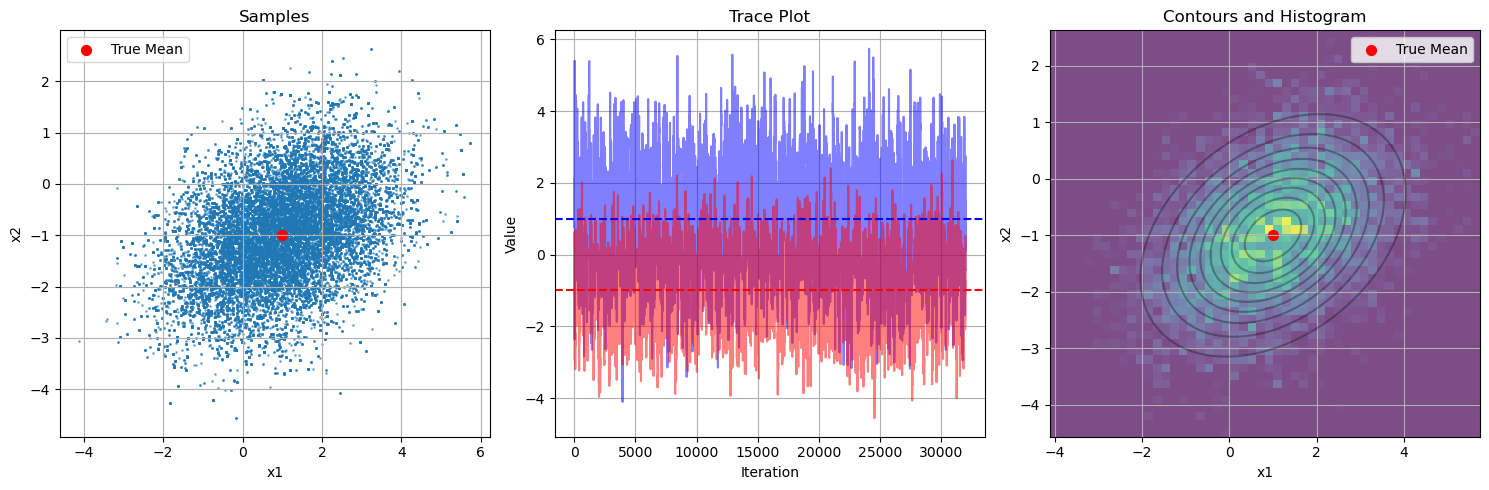

In [308]:
# Test functions remain the same
def test_2d_gaussian():
    print("Test 1: 2D Gaussian distribution")
    
    # Define a 2D Gaussian with non-trivial covariance
    mu = np.array([1.0, -1.0])
    cov = np.array([[2.0, 0.5], [0.5, 1.0]])
    prec = np.linalg.inv(cov)
    
    # Log density, gradient, and Hessian
    def log_posterior(x):
        diff = x - mu
        return -0.5 * diff.T @ prec @ diff
    
    def gradient(x):
        # For sampling toward higher density, gradient points toward the mean
        return -prec @ (x - mu)
    
    def hessian(x):
        # For a Gaussian, the Hessian is the precision matrix (constant)
        return prec
    
    # Run sampler
    initial_point = np.array([0.0, 0.0])
    n_samples = 40000  # More samples for better convergence
    samples, acceptance_rate, dr_stats = gnpl_metropolis_with_dr(log_posterior, gradient, hessian, initial_point, n_samples, 
                           step_size=10.0, n_try=3, shrink_factor=0.2)
    
    # Discard burn-in
    burn_in = 8000
    samples = samples[burn_in:]
    
    # Compute empirical mean and covariance
    empirical_mean = np.mean(samples, axis=0)
    empirical_cov = np.cov(samples.T)
    
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    print(dr_stats)
    print(f"True mean: {mu}")
    print(f"Empirical mean: {empirical_mean}")
    print(f"True covariance:\n{cov}")
    print(f"Empirical covariance:\n{empirical_cov}")
    
    # Compute KL divergence between true and empirical distributions
    def kl_divergence_gaussian(mu1, cov1, mu2, cov2):
        # KL(N(mu1, cov1) || N(mu2, cov2))
        k = len(mu1)
        # Add small regularization to ensure positive-definiteness
        cov1_reg = cov1 + 1e-10 * np.eye(k)
        cov2_reg = cov2 + 1e-10 * np.eye(k)
        cov2_inv = np.linalg.inv(cov2_reg)
        mean_diff = mu2 - mu1
        trace_term = np.trace(cov2_inv @ cov1_reg)
        mean_term = mean_diff.T @ cov2_inv @ mean_diff
        log_det_term = np.log(np.linalg.det(cov2_reg) / np.linalg.det(cov1_reg))
        kl = 0.5 * (trace_term + mean_term - k + log_det_term)
        return kl
    
    kl = kl_divergence_gaussian(mu, cov, empirical_mean, empirical_cov)
    print(f"KL divergence: {kl:.6f}")
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Plot samples
    plt.subplot(1, 3, 1)
    plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
    plt.scatter(mu[0], mu[1], color='red', s=50, label='True Mean')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Samples')
    plt.legend()
    plt.grid(True)
    
    # Plot trace
    plt.subplot(1, 3, 2)
    plt.plot(samples[:, 0], 'b-', alpha=0.5)
    plt.plot(samples[:, 1], 'r-', alpha=0.5)
    plt.axhline(mu[0], color='b', linestyle='--')
    plt.axhline(mu[1], color='r', linestyle='--')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title('Trace Plot')
    plt.grid(True)
    
    # Plot contours
    plt.subplot(1, 3, 3)
    
    # Create grid for contour plot
    x = np.linspace(-4, 6, 100)
    y = np.linspace(-4, 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    # Compute density for each point
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i, j], Y[i, j]])
            Z[i, j] = np.exp(log_posterior(point))
    
    # Plot contours of true distribution
    plt.contour(X, Y, Z, levels=10, colors='k', alpha=0.3)
    
    # Create histogram of samples
    plt.hist2d(samples[:, 0], samples[:, 1], bins=50, cmap='viridis', alpha=0.7)
    
    plt.scatter(mu[0], mu[1], color='red', s=50, label='True Mean')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Contours and Histogram')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# Test case 2: Least-squares problem (non-linear regression)
def test_nonlinear_regression():
    print("\nTest 2: Non-linear regression posterior")
    
    # Generate synthetic data
    np.random.seed(42)
    n_data = 40
    true_params = np.array([2.5, 0.5])
    x_data = np.linspace(0, 10, n_data)
    
    def model(x, params):
        a, b = params
        return a * np.exp(-b * x)
    
    # Add noise to create observations
    sigma = 0.2
    y_true = model(x_data, true_params)
    y_obs = y_true + sigma * np.random.randn(n_data)
    
    # Define log posterior (least squares structure)
    def log_posterior(params):
        if params[1] <= 0:  # Prior constraint: b must be positive
            return -np.inf
        
        residuals = y_obs - model(x_data, params)
        return -0.5 * np.sum(residuals**2) / sigma**2
    
    # Gradient of log posterior
    def gradient(params):
        a, b = params
        if b <= 0:
            return np.array([0.0, 0.0])  # Gradient at boundary
            
        exp_term = np.exp(-b * x_data)
        residuals = y_obs - a * exp_term
        
        grad_a = np.sum(residuals * exp_term) / sigma**2
        grad_b = np.sum(residuals * a * x_data * exp_term) / sigma**2
        
        return np.array([grad_a, grad_b])
    
    # Gaussian-Newton approximation of Hessian
    def hessian(params):
        a, b = params
        if b <= 0:
            return np.eye(2) * 1e3  # Large curvature at boundary
            
        exp_term = np.exp(-b * x_data)
        
        # Jacobian of the model
        J = np.zeros((n_data, 2))
        J[:, 0] = exp_term
        J[:, 1] = -a * x_data * exp_term
        
        # Approximation to Hessian: J.T @ J
        H = (J.T @ J) / sigma**2
        
        # Ensure positive definiteness
        H = 0.5 * (H + H.T)  # Ensure symmetry
        
        return H
    
    # Run sampler
    initial_point = np.array([1.0, 1.0])
    n_samples = 40000
    samples, acceptance_rate, dr_stats = gnpl_metropolis_with_dr(log_posterior, gradient, hessian, initial_point, n_samples, 
                           step_size=0.5, n_try=5, shrink_factor=0.2)
    
    # Discard burn-in
    burn_in = 10000
    samples = samples[burn_in:]
    
    # Compute posterior mean
    posterior_mean = np.mean(samples, axis=0)
    posterior_cov = np.cov(samples.T)
    
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    print(dr_stats)
    print(f"True parameters: {true_params}")
    print(f"Posterior mean: {posterior_mean}")
    print(f"Posterior covariance:\n{posterior_cov}")
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Plot samples
    plt.subplot(1, 3, 1)
    plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
    plt.scatter(true_params[0], true_params[1], color='red', label='True params')
    plt.scatter(posterior_mean[0], posterior_mean[1], color='green', label='Posterior mean')
    plt.xlabel('a')
    plt.ylabel('b')
    plt.title('Parameter Samples')
    plt.legend()
    plt.grid(True)
    
    # Plot trace
    plt.subplot(1, 3, 2)
    plt.plot(samples[:, 0], 'b-', alpha=0.5, label='a')
    plt.plot(samples[:, 1], 'r-', alpha=0.5, label='b')
    plt.axhline(true_params[0], color='b', linestyle='--')
    plt.axhline(true_params[1], color='r', linestyle='--')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title('Trace Plot')
    plt.legend()
    plt.grid(True)
    
    # Plot data and model fit
    plt.subplot(1, 3, 3)
    plt.scatter(x_data, y_obs, label='Data')
    
    # Plot true model
    x_fine = np.linspace(0, 10, 100)
    y_true_fine = model(x_fine, true_params)
    plt.plot(x_fine, y_true_fine, 'r-', label='True model')
    
    # Plot posterior mean model
    y_post_fine = model(x_fine, posterior_mean)
    plt.plot(x_fine, y_post_fine, 'g-', label='Posterior mean model')
    
    # Plot credible intervals
    n_curves = 100
    idx = np.random.choice(len(samples), n_curves)
    for i in idx:
        y_sample = model(x_fine, samples[i])
        plt.plot(x_fine, y_sample, 'b-', alpha=0.05)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Data and Model Fits')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()




test_2d_gaussian()
# test_nonlinear_regression()


Test 3: Neal's funnel distribution
Acceptance rate: 0.72
{'attempts': array([999999., 839288., 542220.]), 'successes': array([160711., 297068., 262156.]), 'rates': array([0.16071116, 0.3539524 , 0.48348641])}
Theoretical v mean: 0.0, Sampled: -0.0531
Theoretical v std: 3.0, Sampled: 2.9677


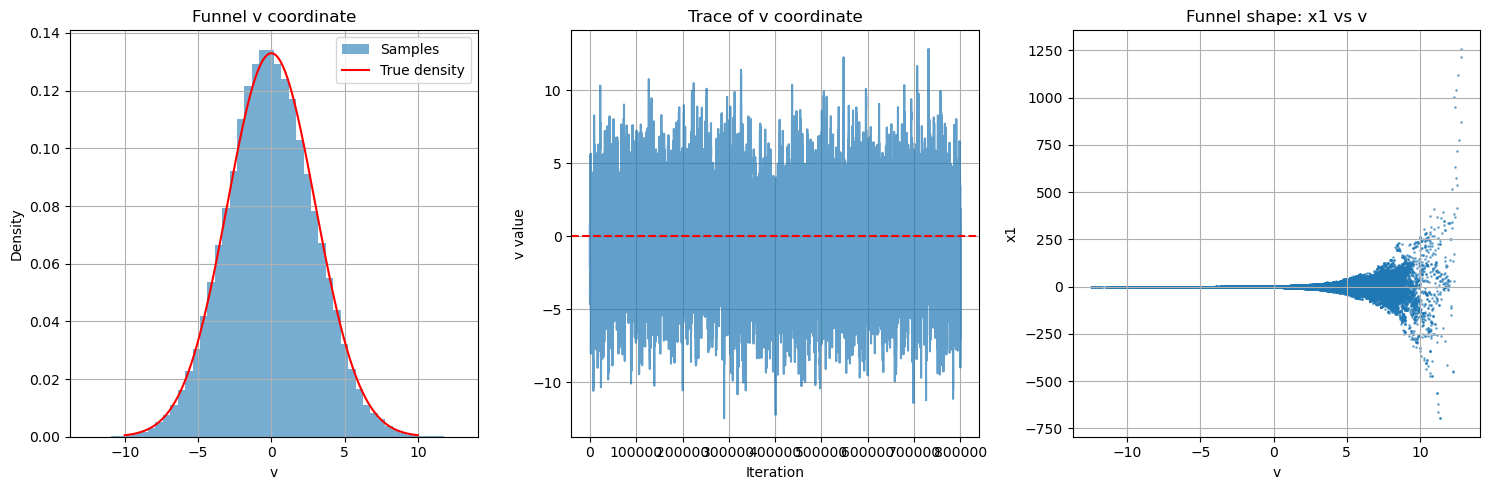

In [10]:
# Test case 3: Neal's funnel distribution
def test_funnel_distribution():
    print("\nTest 3: Neal's funnel distribution")
    
    # Neal's funnel has a challenging geometry for samplers
    # p(v, x) = N(v | 0, 3) * ∏ N(x_i | 0, exp(v))
    
    def log_posterior(theta):
        """Log density of funnel distribution"""
        if len(theta) < 2:
            return -np.inf
            
        v = theta[0]  # First coordinate is v (controls variance)
        x = theta[1:]  # Remaining coordinates are x
        
        # p(v) = N(v | 0, 3)
        log_p_v = -0.5 * v**2 / 9 - 0.5 * np.log(2 * np.pi * 9)
        
        # p(x | v) = N(x | 0, exp(v))
        sigma2_x = np.exp(v)
        log_p_x = -0.5 * np.sum(x**2) / sigma2_x - 0.5 * len(x) * (np.log(2 * np.pi) + v)
        
        return log_p_v + log_p_x
    
    def gradient(theta):
        """Gradient of log density of funnel distribution"""
        v = theta[0]
        x = theta[1:]
        
        # Gradient for v
        grad_v = -v / 9  # From log p(v)
        
        # Additional term from p(x | v)
        sigma2_x = np.exp(v)
        x_sq_sum = np.sum(x**2)
        grad_v += 0.5 * (x_sq_sum / sigma2_x - len(x))
        
        # Gradient for x
        grad_x = -x / sigma2_x
        
        return np.concatenate([[grad_v], grad_x])
    

    
    def hessian(theta):
        """Vectorized Gaussian-Newton approximation of Hessian for funnel distribution"""
        v = theta[0]
        x = theta[1:]
        dim = len(theta)
        
        # Create Jacobian matrix for whitened residuals
        J = np.zeros((dim, dim))
        
        # For v: standardized residual r₁(θ) = v/3
        J[0, 0] = 1.0/3.0
        
        # For x: standardized residuals r₂(θ) = x/exp(v/2)
        sigma_x = np.exp(v/2)  # Standard deviation of x|v
        
        # Derivatives of r₂ with respect to v
        J[1:, 0] = -0.5 * x / sigma_x  # d/dv(x/exp(v/2))
        # J[1:, 0] = - x / sigma_x  # d/dv(x/exp(v/2))

        # Derivatives of r₂ with respect to x (diagonal block)
        indices = np.arange(1, dim)
        J[indices, indices] = 1.0 / sigma_x
        
        # Compute Gaussian-Newton Hessian: H = J^T J
        H = J.T @ J
        
        # Add small regularization for numerical stability
        H += 1e-6 * np.eye(dim)
        return H
    
    # Run sampler
    dim = 5  # 1 for v, 10 for x
    initial_point = np.zeros(dim)
    n_samples = 10**6
    
    # Start from a more reasonable point
    initial_point[0] = 0.0  # v starts at 0
    initial_point[1:] = np.random.randn(dim-1) * 0.1  # x starts small
    
    samples, acceptance_rate, dr_stats = gnpl_metropolis_with_dr(
        log_posterior, gradient, hessian, initial_point, n_samples,
        step_size=0.2/np.sqrt(dim), n_try=3, shrink_factor=0.2
    )
    
    # Discard burn-in
    burn_in = 2*10**5
    samples = samples[burn_in:]
    
    # Statistics
    v_samples = samples[:, 0]
    v_mean = np.mean(v_samples)
    v_std = np.std(v_samples)
    
    print(f"Acceptance rate: {acceptance_rate:.2f}")
    print(dr_stats)
    print(f"Theoretical v mean: 0.0, Sampled: {v_mean:.4f}")
    print(f"Theoretical v std: 3.0, Sampled: {v_std:.4f}")
    
    # Prepare true density for v (marginal)
    v_range = np.linspace(-10, 10, 1000)
    true_v_density = np.exp(-0.5 * v_range**2 / 9) / np.sqrt(2 * np.pi * 9)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Plot v histogram vs true density
    plt.subplot(1, 3, 1)
    plt.hist(v_samples, bins=50, density=True, alpha=0.6, label='Samples')
    plt.plot(v_range, true_v_density, 'r-', label='True density')
    plt.xlabel('v')
    plt.ylabel('Density')
    plt.title('Funnel v coordinate')
    plt.legend()
    plt.grid(True)
    
    # Plot trace of v
    plt.subplot(1, 3, 2)
    plt.plot(v_samples, alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Iteration')
    plt.ylabel('v value')
    plt.title('Trace of v coordinate')
    plt.grid(True)
    
    # Plot x1 vs v to show funnel shape
    plt.subplot(1, 3, 3)
    plt.scatter(v_samples, samples[:, 1], s=1, alpha=0.5)
    plt.xlabel('v')
    plt.ylabel('x1')
    plt.title('Funnel shape: x1 vs v')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return samples

samples = test_funnel_distribution()

428.78499762428606 1865.7369181115412
143.0150820345401 5593.81562153556
90.23338079177583 8865.898550848875


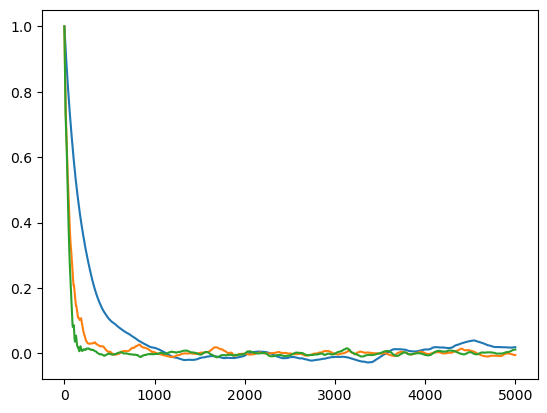

In [11]:
acf = np.zeros((5000, 3))
for i in range(3):
    acf[:, i] = autocorrelation_fft(samples[:, i], max_lag=5000)
plt.plot(range(5000), acf)
for i in range(3):
    tau, acf, ess = integrated_autocorr_time(samples[:, i], M=5, c=10)
    print(tau, ess)


Testing exp(-||x||^4) distribution

Results (dim=5):
Acceptance rate: 0.397
DR rates: [0.04821048 0.0554645  0.08516224 0.1220651  0.16474157]

Accuracy check:
Mean:     True=0.000, Sampled=0.001
E[x²]:    True=0.338, Sampled=0.344
E[||x||²]: True=1.690, Sampled=1.672

Errors:
Mean error:     0.0011
E[x²] error:    0.0055
E[||x||²] error: 0.0183


/var/folders/r1/mcbxhrz15w781rksjrkrm5sr0000gn/T/ipykernel_48233/3681885350.py:83: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  true_density = true_density / integrate.trapz(true_density, x_range)


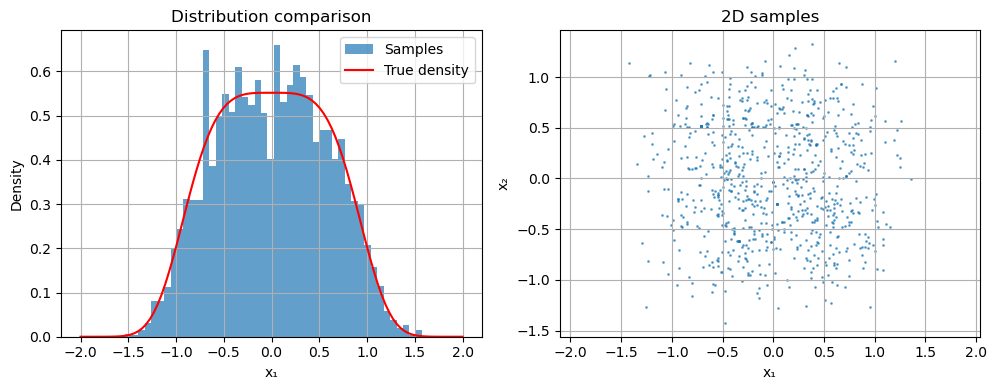

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

def test_unbounded_lipschitz_simple():
    """
    Simple test of exp(-||x||^4) distribution to check sampling accuracy.
    """
    print("Testing exp(-||x||^4) distribution")
    
    def log_posterior(theta):
        """Log density: -||x||^4"""
        return -np.sum(theta**4)
    
    def gradient(theta):
        """Gradient: -4*x^3"""
        return -4 * theta**3
    
    def hessian(theta):
        """Gaussian-Newton Hessian"""
        dim = len(theta)
        # Write ||x||^4 = sum(x_i^4) = sum((x_i^2)^2) as ||r||^2 where r_i = x_i^2
        # Jacobian: dr_i/dx_j = 2*x_i*delta_ij
        # GN Hessian: J^T J gives diagonal with 4*x_i^2
        H = np.diag(4 * theta**2) + 1e-3 * np.eye(dim)
        return H
    
    # True moments (analytical)
    # For exp(-x^4), E[x^2] = Gamma(3/4)/Gamma(1/4) 
    # For d dimensions: E[||x||^2] = d * Gamma(3/4)/Gamma(1/4)
    from scipy.special import gamma
    true_second_moment_1d = gamma(0.75) / gamma(0.25)  # Gamma(3/4)/Gamma(1/4)

    # Test sampling
    dim = 5
    initial_point = np.zeros(dim)+1.0*np.random.randn(dim)  # Start from a small random point
    n_samples = 10**5
    
    samples, acceptance_rate, dr_stats = gnpl_metropolis_with_dr(
        log_posterior, gradient, hessian, initial_point, n_samples,
        step_size=0.5, n_try=5, shrink_factor=0.2
    )
    
    # Remove burn-in
    samples = samples[20000:]
    
    # Compute moments
    sample_mean = np.mean(samples, axis=0)
    sample_second_moments = np.mean(samples**2, axis=0)
    sample_norm_squared = np.mean(np.sum(samples**2, axis=1))
    
    # Compare to truth
    true_mean = np.zeros(dim)
    true_second_moment_per_dim = true_second_moment_1d
    true_norm_squared = dim * true_second_moment_1d
    
    print(f"\nResults (dim={dim}):")
    print(f"Acceptance rate: {acceptance_rate:.3f}")
    print(f"DR rates: {dr_stats['rates']}")
    print(f"\nAccuracy check:")
    print(f"Mean:     True={true_mean[0]:.3f}, Sampled={sample_mean[0]:.3f}")
    print(f"E[x²]:    True={true_second_moment_per_dim:.3f}, Sampled={sample_second_moments[0]:.3f}")
    print(f"E[||x||²]: True={true_norm_squared:.3f}, Sampled={sample_norm_squared:.3f}")
    
    # Errors
    mean_error = np.abs(sample_mean[0] - true_mean[0])
    second_moment_error = np.abs(sample_second_moments[0] - true_second_moment_per_dim)
    norm_error = np.abs(sample_norm_squared - true_norm_squared)
    
    print(f"\nErrors:")
    print(f"Mean error:     {mean_error:.4f}")
    print(f"E[x²] error:    {second_moment_error:.4f}")
    print(f"E[||x||²] error: {norm_error:.4f}")
    
    # Simple plot
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(samples[:, 0], bins=50, density=True, alpha=0.7, label='Samples')
    x_range = np.linspace(-2, 2, 100)
    # True 1D density (normalized)
    true_density = np.exp(-x_range**4)
    true_density = true_density / integrate.trapz(true_density, x_range)
    plt.plot(x_range, true_density, 'r-', label='True density')
    plt.xlabel('x₁')
    plt.ylabel('Density')
    plt.title('Distribution comparison')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.scatter(samples[::100, 0], samples[::100, 1], s=1, alpha=0.6)
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.title('2D samples')
    plt.grid(True)
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    return samples

# Run test
if __name__ == "__main__":
    samples = test_unbounded_lipschitz_simple()

0.3379891200336423


Testing 2D Rosenbrock with Gaussian-Newton

Results:
Acceptance rate: 0.241
DR rates: [0.04173042 0.06255087 0.15546798]

Accuracy (should be close to [1,1,...,1]):
Sample mean: [ 2.40109291 11.35547206]
Sample std:  [ 2.3685956  14.38382324]
Mean error: 10.4498


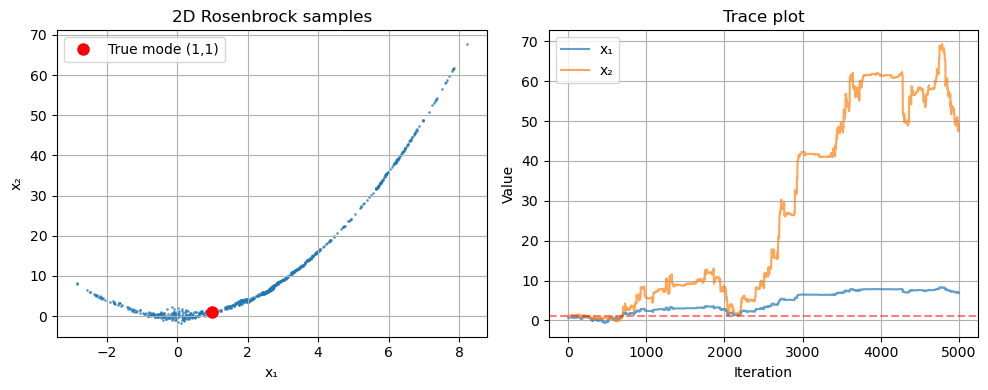

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def test_rosenbrock_simple(dim=4):
    """
    Simple Rosenbrock test with Gaussian-Newton, general dimension.
    f(x) = sum_{i=1}^{d-1} [100(x_{i+1} - x_i^2)^2 + (1 - x_i)^2] / 100
    """
    print(f"Testing {dim}D Rosenbrock with Gaussian-Newton")
    
    def log_posterior(x):
        """Vectorized negative Rosenbrock function"""
        if len(x) < 2:
            return -np.inf
        
        # Vectorized: f = sum[100(x[1:] - x[:-1]^2)^2 + (1 - x[:-1])^2]
        diff = x[1:] - x[:-1]**2
        f = np.sum(100 * diff**2 + (1 - x[:-1])**2)
        return -f/100
    
    def gradient(x):
        """Vectorized gradient of negative Rosenbrock"""
        n = len(x)
        grad = np.zeros(n)
        
        # Vectorized computation
        x_prev = x[:-1]  # x[0] to x[n-2]
        x_next = x[1:]   # x[1] to x[n-1]
        
        # Gradient for interior points (vectorized)
        grad[:-1] += -400 * x_prev * (x_next - x_prev**2) - 2 * (1 - x_prev)
        grad[1:] += -200 * (x_next - x_prev**2)
        
        return grad/100
    
    def hessian_gaussian_newton(x):
        """Vectorized Gaussian-Newton Hessian for Rosenbrock"""
        n = len(x)
        
        # Vectorized Jacobian construction
        # Residuals: r_i = 10(x_{i+1} - x_i^2), s_i = (1 - x_i)
        num_residuals = 2 * (n - 1)
        J = np.zeros((num_residuals, n))
        
        # Vectorized filling
        indices = np.arange(n - 1)
        
        # r_i residuals (even rows)
        J[2*indices, indices] = -20 * x[indices]      # dr_i/dx_i
        J[2*indices, indices + 1] = 10                # dr_i/dx_{i+1}
        
        # s_i residuals (odd rows)
        J[2*indices + 1, indices] = -1                # ds_i/dx_i
        
        # GN Hessian: J^T @ J (vectorized)
        H = J.T @ J + 1e-6 * np.eye(n)
        return H/100
    
    # True solution: x* = [1, 1, ..., 1]
    true_solution = np.ones(dim)
    
    # Sample
    initial_point = np.zeros(dim)
    n_samples = 10**5
    
    samples, acceptance_rate, dr_stats = gnpl_metropolis_with_dr(
        log_posterior, gradient, hessian_gaussian_newton, initial_point, n_samples,
        step_size=0.01, n_try=3, shrink_factor=0.1
    )
    
    # Remove burn-in
    samples = samples[20000:]
    
    # Statistics
    sample_mean = np.mean(samples, axis=0)
    sample_std = np.std(samples, axis=0)
    
    print(f"\nResults:")
    print(f"Acceptance rate: {acceptance_rate:.3f}")
    print(f"DR rates: {dr_stats['rates']}")
    print(f"\nAccuracy (should be close to [1,1,...,1]) this is wrong:")
    print(f"Sample mean: {sample_mean}")
    print(f"Sample std:  {sample_std}")
    print(f"Mean error: {np.linalg.norm(sample_mean - true_solution):.4f}")
    
    # Plot for 2D case
    if dim == 2:
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.scatter(samples[::100, 0], samples[::100, 1], s=1, alpha=0.6)
        plt.plot(1, 1, 'ro', markersize=8, label='True mode (1,1)')
        plt.xlabel('x₁')
        plt.ylabel('x₂')
        plt.title('2D Rosenbrock samples')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(samples[-5000:, 0], alpha=0.7, label='x₁')
        plt.plot(samples[-5000:, 1], alpha=0.7, label='x₂')
        plt.axhline(1, color='r', linestyle='--', alpha=0.5)
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.title('Trace plot')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    return samples

# Test different dimensions
if __name__ == "__main__":
    d = 2
    samples = test_rosenbrock_simple(dim=d)


Testing 4D singular distribution: p(x) ∝ 1/||x||^1.0

Results:
Acceptance rate: 0.997
DR rates: [0.99669997 0.00909091 0.00917431]
Sample mean: [-2524.36765837   401.0495568   5306.77588745  -398.10122076]
Mean ||x||: 6435.2769
Min ||x||: 2358.438399 (smaller = closer to singularity)


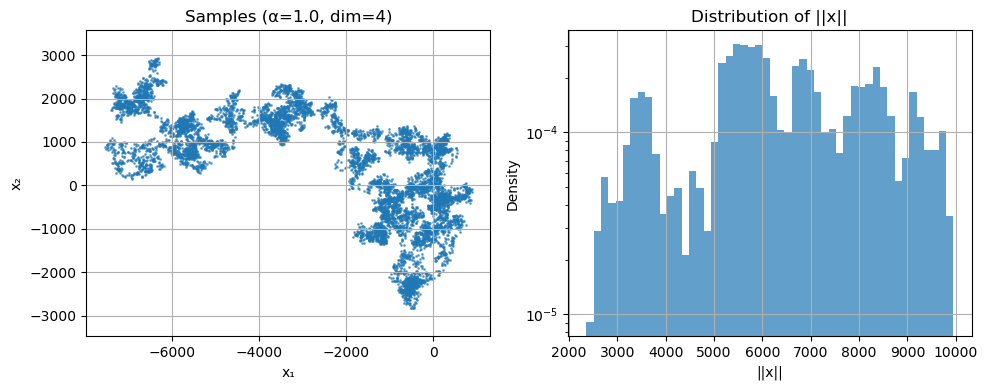

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def test_singular_simple(alpha=0.5, dim=2):
    """
    Simple test of singular distribution p(x) ∝ 1/||x||^α
    Only uses Gaussian-Newton Hessian.
    """
    print(f"Testing {dim}D singular distribution: p(x) ∝ 1/||x||^{alpha}")
    
    def log_posterior(x):
        """Log density: -α*log(||x||)"""
        norm = np.linalg.norm(x)
        if norm < 1e-8:  # Avoid singularity
            norm = 1e-8
        return -alpha * np.log(norm)
    
    def gradient(x):
        """Gradient: -α * x/||x||²"""
        norm_sq = np.sum(x**2)
        if norm_sq < 1e-16:
            norm_sq = 1e-16
        return -alpha * x / norm_sq
    
    def hessian_gaussian_newton(x):
        """Gaussian-Newton approximation"""
        n = len(x)
        norm_sq = np.sum(x**2)
        if norm_sq < 1e-16:
            norm_sq = 1e-16
        
        # Single residual: r = √α * log(||x||)
        # Jacobian: ∇r = √α * x/||x||²
        J = np.sqrt(alpha) * x.reshape(1, -1) / norm_sq
        
        # GN Hessian: J^T @ J
        H = J.T @ J + 1e-3 * np.eye(n)
        return H
    
    # Sample
    initial_point = np.ones(dim) * 0.5  # Start away from origin
    n_samples = 10**5
    
    samples, acceptance_rate, dr_stats = gnpl_metropolis_with_dr(
        log_posterior, gradient, hessian_gaussian_newton, initial_point, n_samples,
        step_size=0.1, n_try=3, shrink_factor=0.2
    )
    
    # Remove burn-in
    samples = samples[20000:]
    
    # Statistics
    sample_mean = np.mean(samples, axis=0)
    sample_norms = np.linalg.norm(samples, axis=1)
    mean_norm = np.mean(sample_norms)
    min_norm = np.min(sample_norms)
    
    print(f"\nResults:")
    print(f"Acceptance rate: {acceptance_rate:.3f}")
    print(f"DR rates: {dr_stats['rates']}")
    print(f"Sample mean: {sample_mean}")
    print(f"Mean ||x||: {mean_norm:.4f}")
    print(f"Min ||x||: {min_norm:.6f} (smaller = closer to singularity)")
    
    # Simple plot (first 2 coordinates for any dimension)
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.scatter(samples[::10, 0], samples[::10, 1], s=1, alpha=0.6)
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.title(f'Samples (α={alpha}, dim={dim})')
    plt.grid(True)
    plt.axis('equal')
    
    plt.subplot(1, 2, 2)
    plt.hist(sample_norms, bins=50, density=True, alpha=0.7)
    plt.xlabel('||x||')
    plt.ylabel('Density')
    plt.title('Distribution of ||x||')
    plt.yscale('log')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return samples

# Test different dimensions and singularity strengths
if __name__ == "__main__":
    for dim in [4]:
        for alpha in [1.0]:
            if alpha >= dim:  # Skip non-integrable cases
                continue
            print(f"\n{'='*40}")
            samples = test_singular_simple(alpha=alpha, dim=dim)
            print(f"{'='*40}")